# Seasonal and time series analysis

## Initial setup

### Load modules

In [1]:
# modules in this package
import load_and_preprocess as lp
import analysis as at
import bic_and_aic as ba
import plot_tools as pt
import file_io as io
import numpy as np
import xarray as xr
import density
import gmm
# plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import cmocean
# os tools
import os.path

# suppress a particular warning
import warnings
warnings.filterwarnings('ignore', 'RuntimeWarning: All-NaN slice encountered')

### Set runtime parameters (file locations, etc.)

In [2]:
# set locations and names
descrip = 'WeddellOnly' # extra description for filename
data_location = '../../so-chic-data/' # input data location
classified_data_location = 'models/profiles_-65to80lon_-85to-30lat_20to1000depth_5K_allDomain_revised.nc'
ploc = 'plots/plots_WeddellClassOnly_top1000m_K04_forPaper/'
#ploc = 'tests/'
dloc = 'models/'

# if plot directory doesn't exist, create it
if not os.path.exists(ploc):
    os.makedirs(ploc)

# save the processed output as a NetCDF file?
saveOutput = False

# number of PCA components (roughly 95%)
n_pca = 6

# make decision about n_components_selected (iterative part of analysis)
n_components_selected = 4

#longitude and latitude range
lon_min = -65
lon_max =  80
lat_min = -80
lat_max = -45
# depth range
zmin = 20.0
zmax = 1000.0
# density range
sig0range = (26.6, 28.0)

# temperature and salinity ranges for plotting
lon_range=(lon_min, lon_max)
lat_range=(lat_min, lat_max)
Trange=(-2.2, 6.0)
Srange=(33.5, 35.0)

# create filename for saving GMM and saving labelled profiles
pca_fname = dloc + 'pca_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_pca)) + descrip
gmm_fname = dloc + 'gmm_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip
fname = dloc + 'profiles_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip + '.nc'

# colormap
colormap = plt.get_cmap('Dark2', n_components_selected)
colormap_cividis = plt.get_cmap('cividis', 20)

### Load classified profile data

In [3]:
dfp = xr.open_dataset("weddell_classified_n4.nc")

### Interpolate onto density surfaces

In [4]:
# regrid onto finer vertical pressure grid
dfp = lp.regrid_onto_more_vertical_levels(dfp, zmin=20, zmax=1000)

# interpolate onto density surfaces
dfp = lp.regrid_onto_density_levels(dfp, np.linspace(27.4, 27.8, 5))
dfp

load_and_preprocess.regrid_onto_more_vertical_levels
load_and_preprocess.regrid_onto_density_levels


<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4, depth_mid: 20, depth_highz: 50, sig0_levs: 5)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 ...
    lat            (profile) float64 ...
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] ...
    year           (profile) int64 ...
    month          (profile) int64 ...
  * CLASS          (CLASS) int64 0 1 2 3
  * depth_mid      (depth_mid) float64 30.0 50.0 70.0 90.0 ... 775.0 865.0 955.0
  * depth_highz    (depth_highz) float64 20.0 40.0 60.0 ... 960.0 980.0 1e+03
  * sig0_levs      (sig0_levs) float64 27.4 27.5 27.6 27.7 27.8
Data variables: (12/28)
    prof_date      (profile) float64 ...
    prof_YYYYMMDD  (profile) float64 ...
    prof_HHMMSS    (profile) float64 ...
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 ...
    prof_CT        (profile, depth) float64 ...
    ...             ...
    ct_on_highz    (profile, depth_highz) float64 -0.1931 -0.8729 ... 1.466
    sa_on_highz    (profile, depth_highz) float64 33.58 33.82 ... 34.9 34.9
    sig0_on_highz  (profile, depth_highz) float64 26.84 27.07 ... 27.8 27.8
    ct_on_sig0     (profile, sig0_levs) float64 -1.437 -1.281 ... 1.901 1.496
    sa_on_sig0     (profile, sig0_levs) float64 34.21 34.34 34.5 ... 34.81 34.9
    z_on_sig0      (profile, sig0_levs) float64 63.96 94.19 ... 400.5 961.5

In [5]:
# select the top pressure level for plotting purposes
df1D = dfp.isel(depth=0)

## Map out individual seasons

Helper function to add season as a coordinate

In [6]:
def add_season_coordinate(dfp):
    
    import xarray as xr
    
    nsize = dfp.profile.size
    month = dfp.month.values
    season = np.zeros((nsize,), dtype='int')
    
    # assign season based on the month (1=DJF, 2=MAM, 3=JJA, 4=SON)
    for i in range(nsize):
        if (month[i]==12 or month[i]==1 or month[i]==2):
            season[i] = 1
        elif (month[i]==3 or month[i]==4 or month[i]==5):
            season[i] = 2
        elif (month[i]==6 or month[i]==7 or month[i]==8):
            season[i] = 3
        elif (month[i]==9 or month[i]==10 or month[i]==11):
            season[i] = 4
        else:
            season[i] = None

    # add season to DataArray
    dseason = xr.DataArray(season, dims=['profile'])
    dfp['season'] = dseason
    dfp = dfp.set_coords({'season'})
    
    return dfp

In [7]:
dfp = add_season_coordinate(dfp)
dfp

<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4, depth_mid: 20, depth_highz: 50, sig0_levs: 5)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 -26.44 -22.37 -17.38 ... 53.09 53.33 53.76
    lat            (profile) float64 -55.98 -56.81 -57.51 ... -58.46 -58.59
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2020-10-1...
    year           (profile) int64 1973 1973 1973 1973 ... 2020 2020 2020 2020
    month          (profile) int64 1 1 1 1 1 1 1 1 1 1 ... 8 8 8 9 9 9 9 9 10 10
  * CLASS          (CLASS) int64 0 1 2 3
  * depth_mid      (depth_mid) float64 30.0 50.0 70.0 90.0 ... 775.0 865.0 955.0
  * depth_highz    (depth_highz) float64 20.0 40.0 60.0 ... 960.0 980.0 1e+03
  * sig0_levs      (sig0_levs) float64 27.4 27.5 27.6 27.7 27.8
    season         (profile) int64 1 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 4 4 4 4 4 4 4
Data variables: (12/28)
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.381e+05 7.381e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.02e+07 2.02e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 ... 4.45e+04 5.19e+04
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 ...
    prof_CT        (profile, depth) float64 ...
    ...             ...
    ct_on_highz    (profile, depth_highz) float64 -0.1931 -0.8729 ... 1.466
    sa_on_highz    (profile, depth_highz) float64 33.58 33.82 ... 34.9 34.9
    sig0_on_highz  (profile, depth_highz) float64 26.84 27.07 ... 27.8 27.8
    ct_on_sig0     (profile, sig0_levs) float64 -1.437 -1.281 ... 1.901 1.496
    sa_on_sig0     (profile, sig0_levs) float64 34.21 34.34 34.5 ... 34.81 34.9
    z_on_sig0      (profile, sig0_levs) float64 63.96 94.19 ... 400.5 961.5

## T-S histograms by season

### TS MLD DJF

plot_tools.plot_hist_map


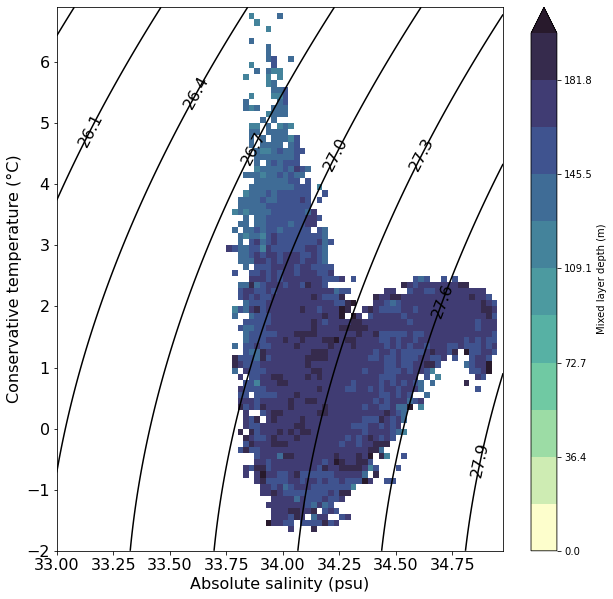

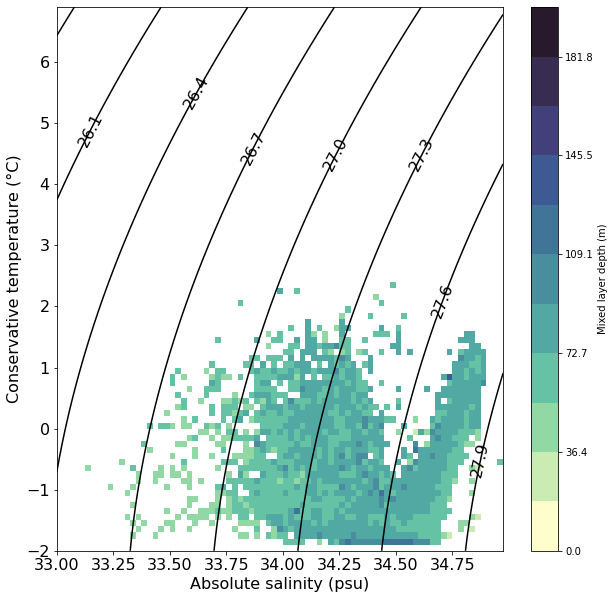

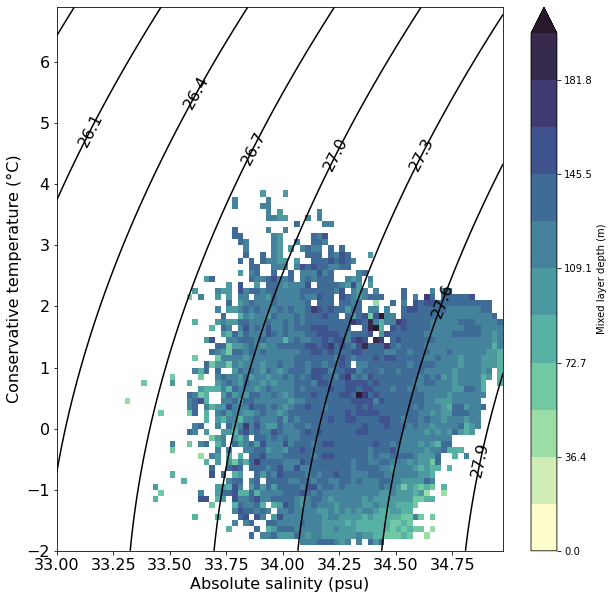

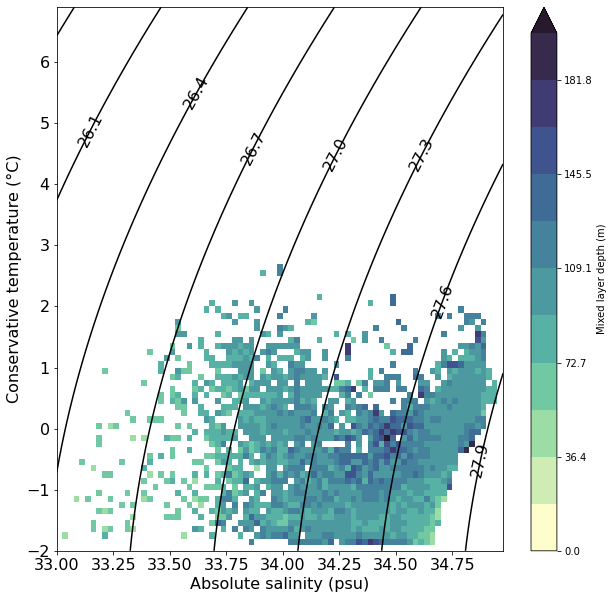

In [8]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==1, drop=True), n_components_selected,
                sbins = np.arange(33, 35, 0.025), 
                tbins = np.arange(-2, 7, 0.1),
                crange=[0,200],
                vartype='mld',
                colormap=cmocean.cm.deep,
                moreText='DJF')

### T-S MLD MAM

plot_tools.plot_hist_map


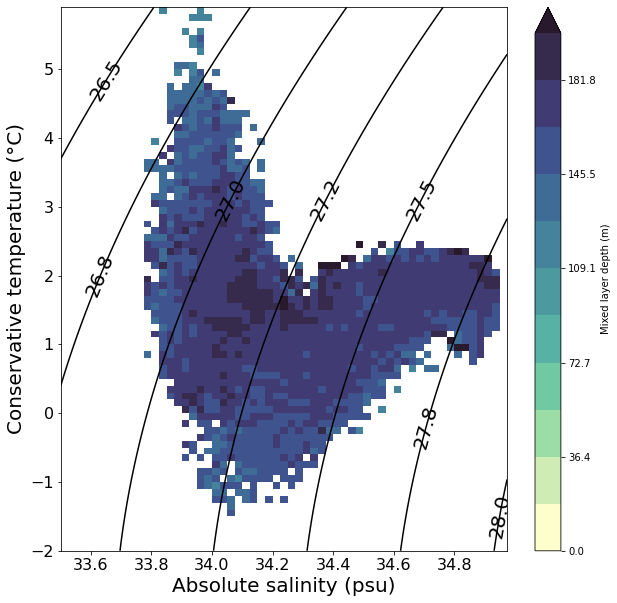

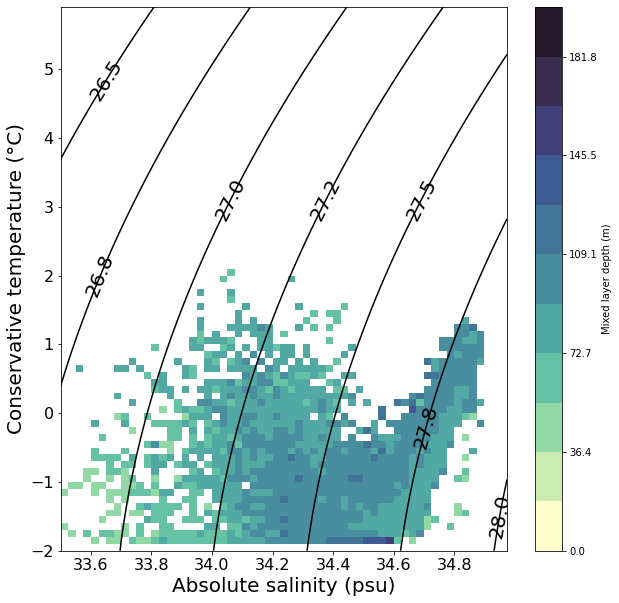

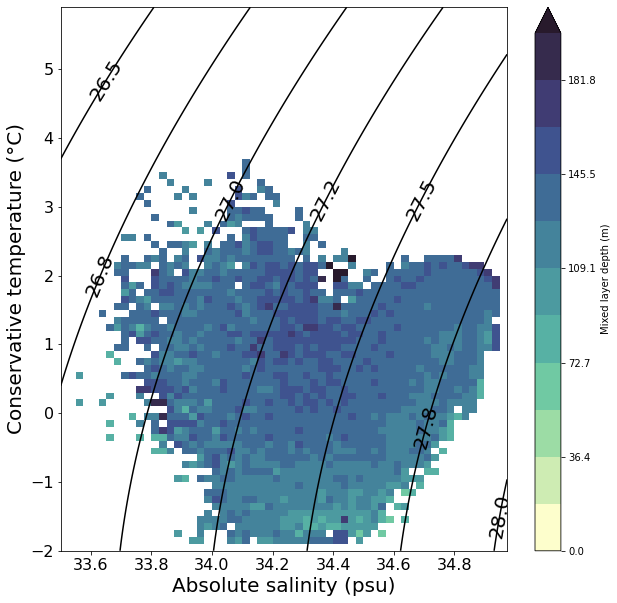

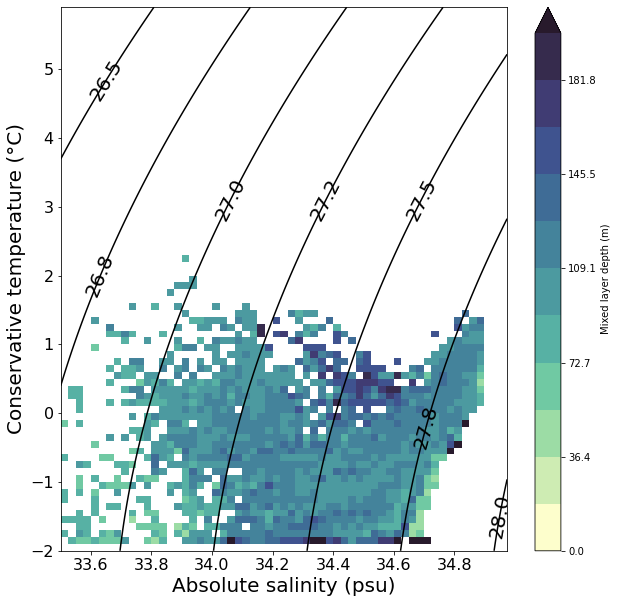

In [9]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==2, drop=True), n_components_selected,
                sbins = np.arange(33.5, 35, 0.025), 
                tbins = np.arange(-2, 6, 0.1),
                crange=[0,200],
                vartype='mld',
                colormap=cmocean.cm.deep,
                moreText='MAM',
                fs=20)

### T-S MLD JJA

plot_tools.plot_hist_map


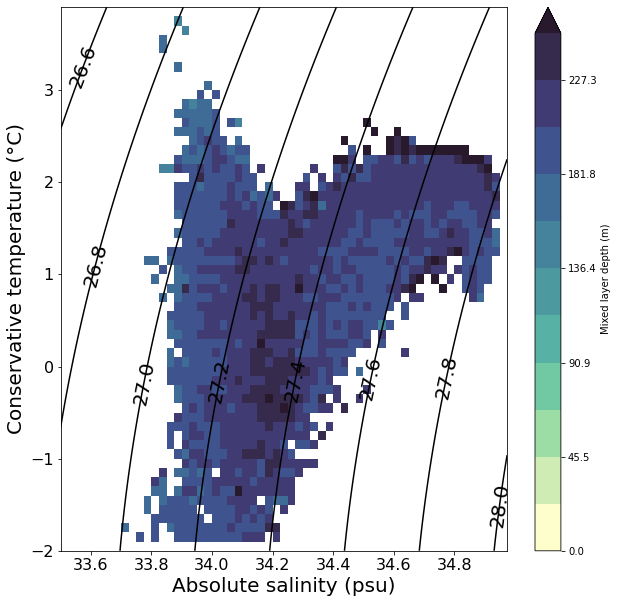

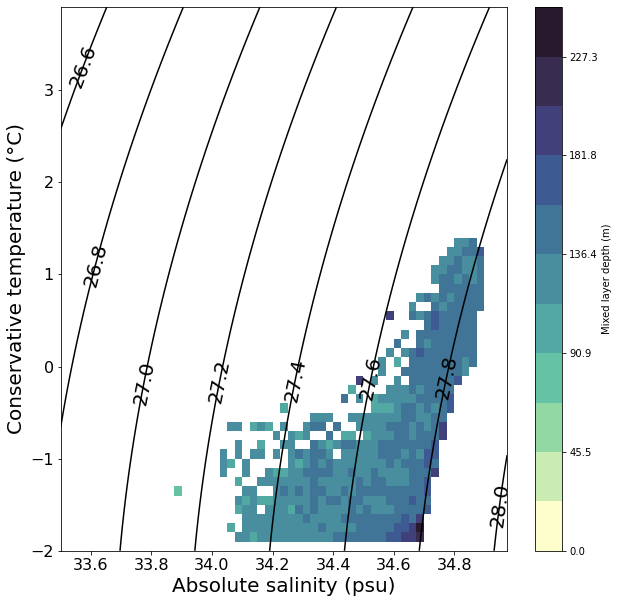

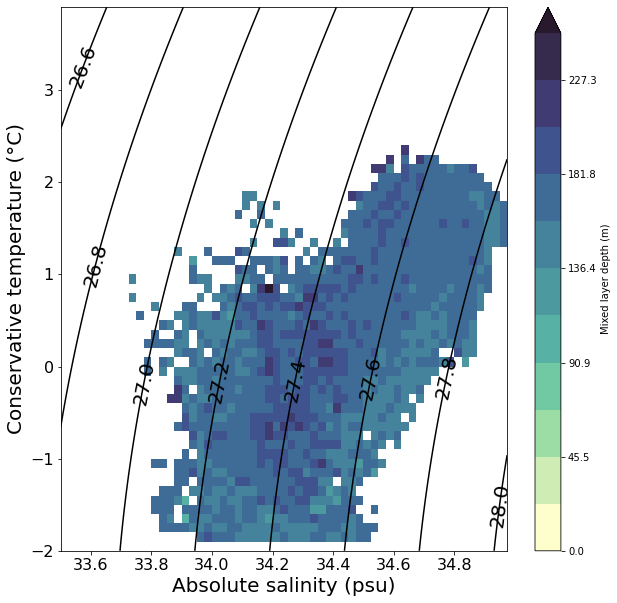

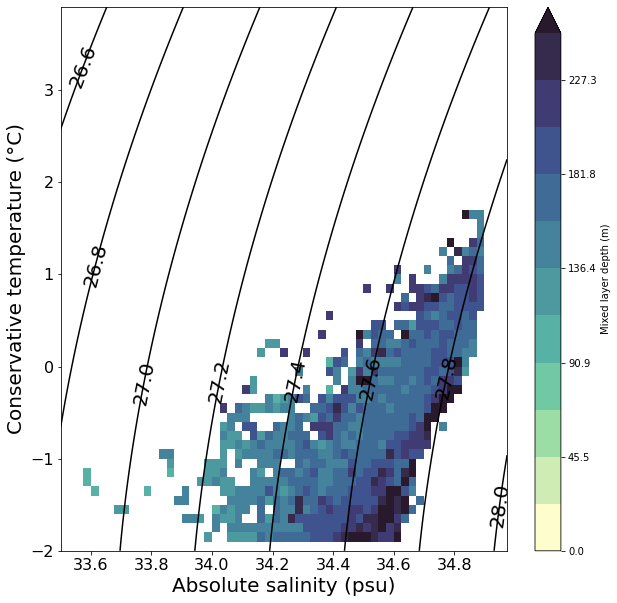

In [10]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==3, drop=True), n_components_selected,
                sbins = np.arange(33.5, 35, 0.025), 
                tbins = np.arange(-2, 4, 0.1),
                crange=[0,250],
                vartype='mld',
                colormap=cmocean.cm.deep,
                moreText='JJA',
                fs=20)

### T-S MLD SON

plot_tools.plot_hist_map


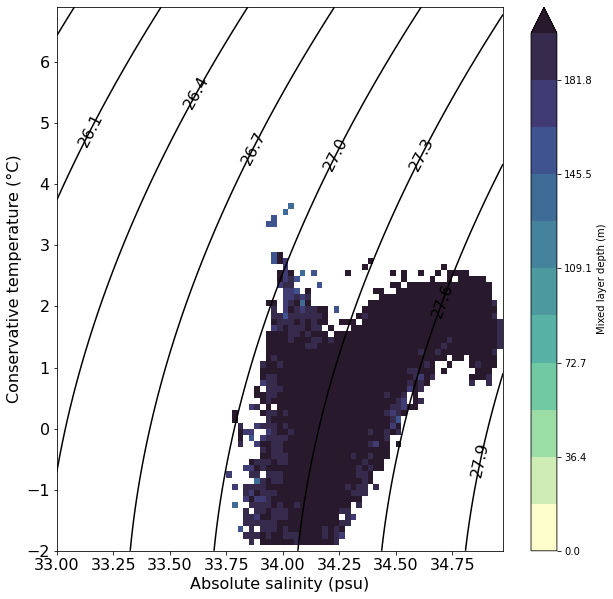

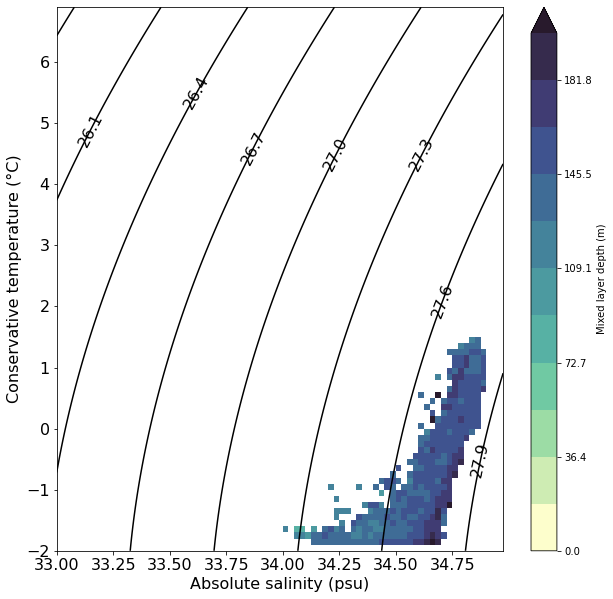

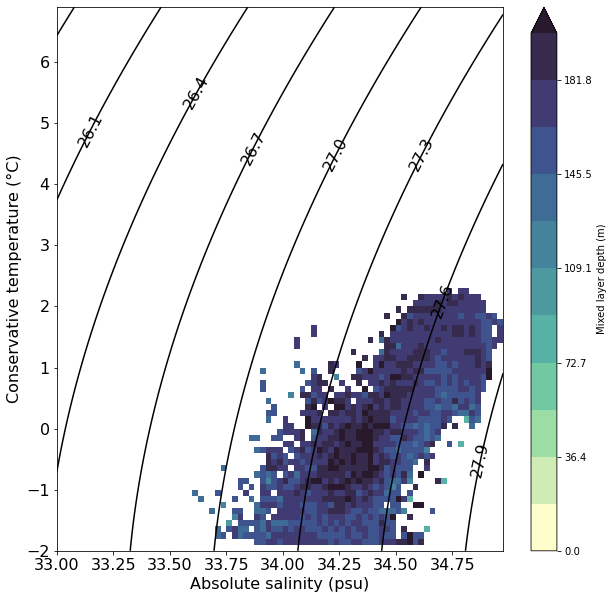

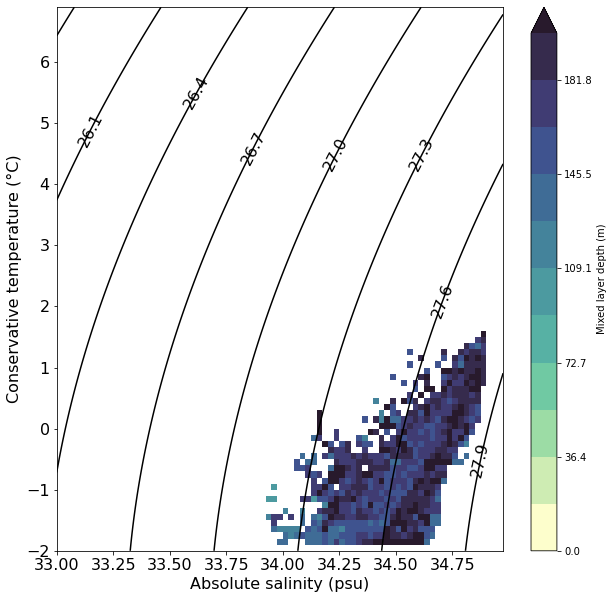

In [11]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==4, drop=True), n_components_selected,
                sbins = np.arange(33, 35, 0.025), 
                tbins = np.arange(-2, 7, 0.1),
                crange=[0,200],
                vartype='mld',
                colormap=cmocean.cm.deep,
                moreText='SON')

## Profile stats by class and season

### DJF

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


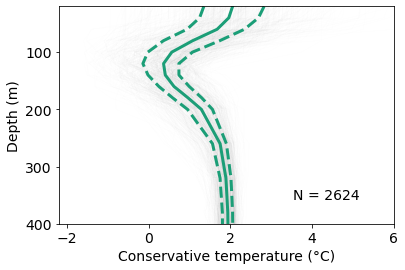

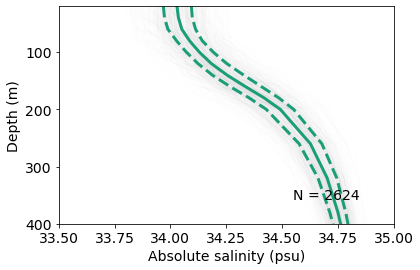

plot_tools.plot_many_profiles


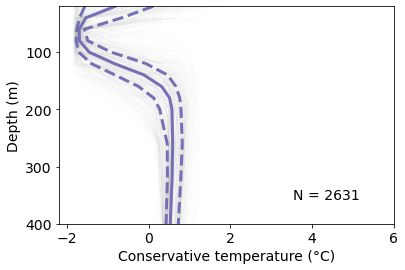

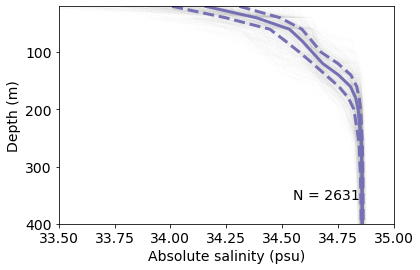

plot_tools.plot_many_profiles


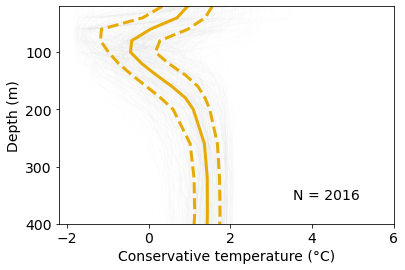

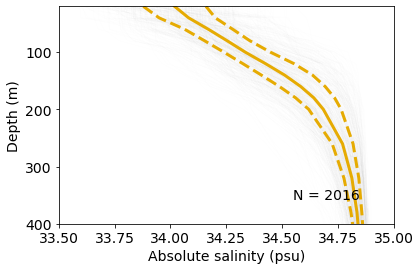

plot_tools.plot_many_profiles


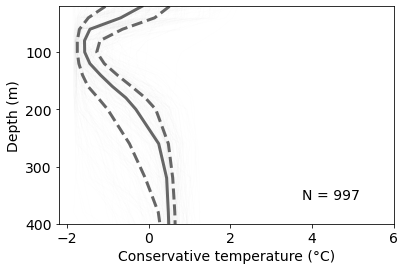

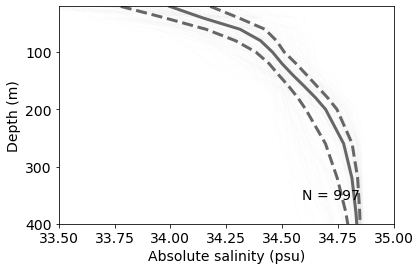

In [12]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==1, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='DJF',
                                  withDensity=False)

### MAM

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


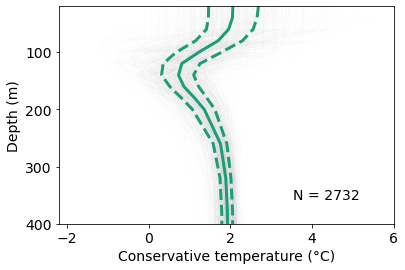

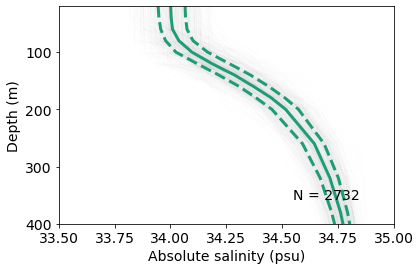

plot_tools.plot_many_profiles


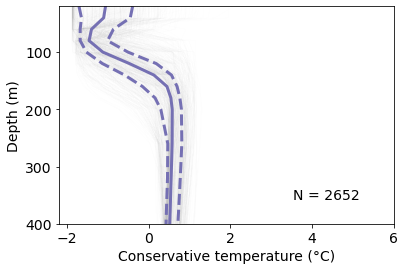

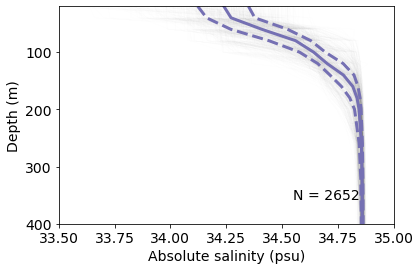

plot_tools.plot_many_profiles


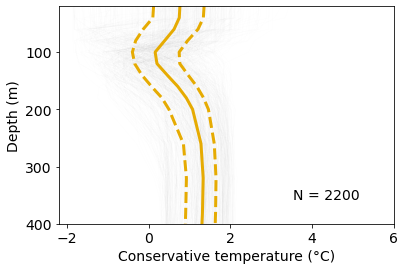

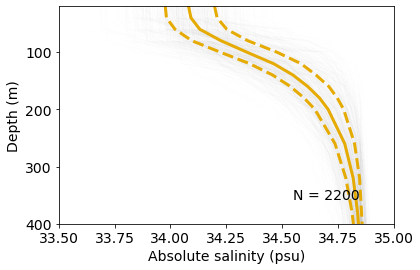

plot_tools.plot_many_profiles


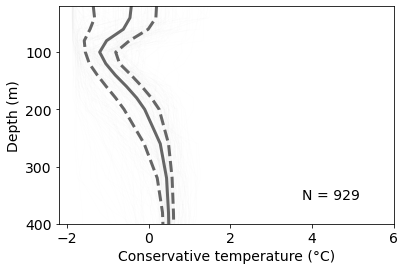

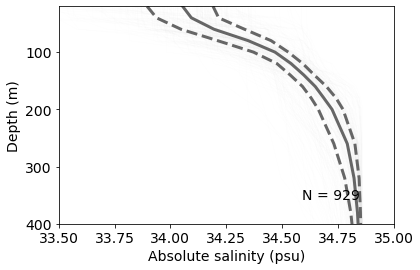

In [13]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==2, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='MAM',
                                  withDensity=False)

### JJA

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


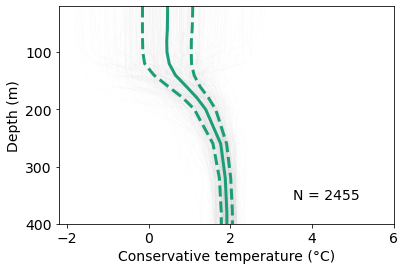

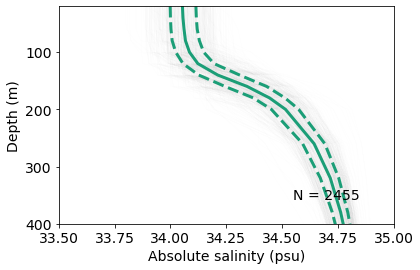

plot_tools.plot_many_profiles


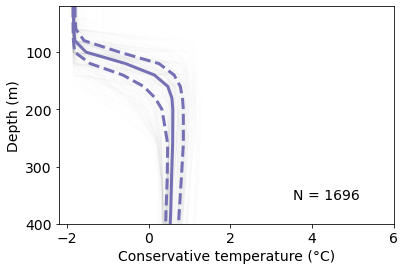

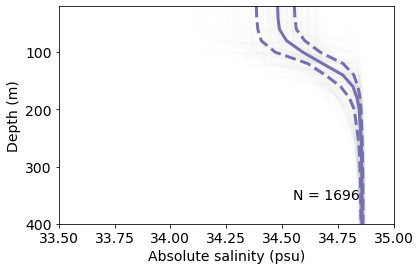

plot_tools.plot_many_profiles


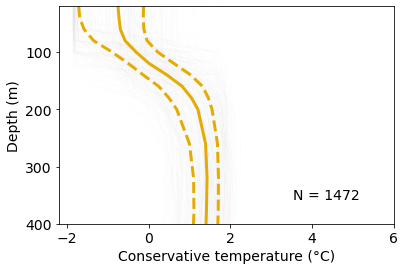

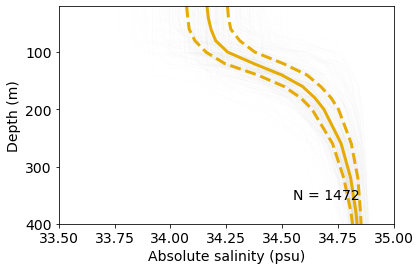

plot_tools.plot_many_profiles


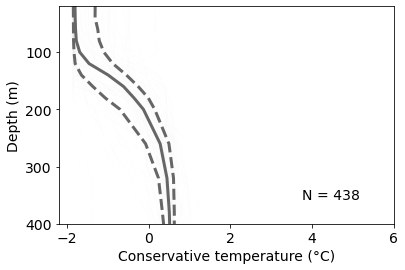

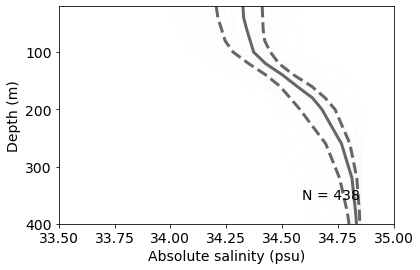

In [14]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==3, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='JJA',
                                  withDensity=False)

### SON

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


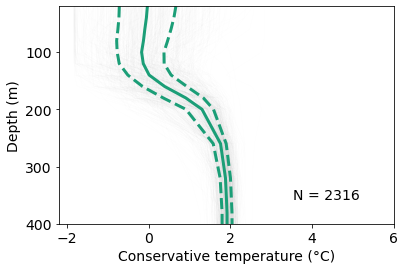

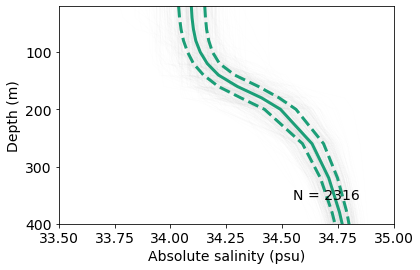

plot_tools.plot_many_profiles


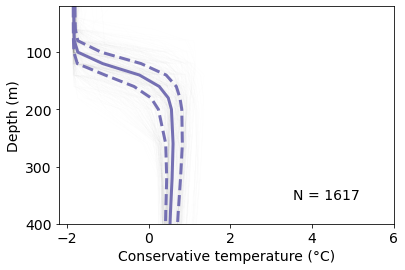

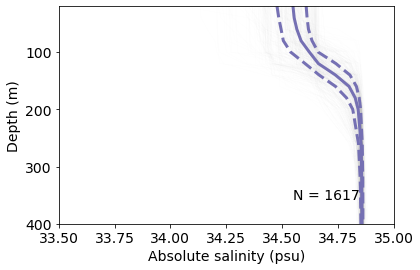

plot_tools.plot_many_profiles


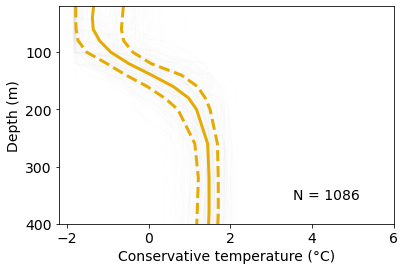

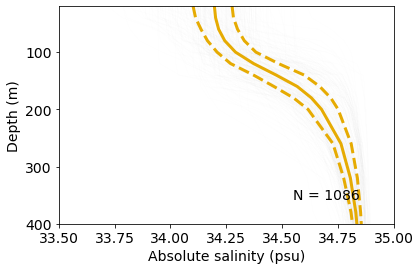

plot_tools.plot_many_profiles


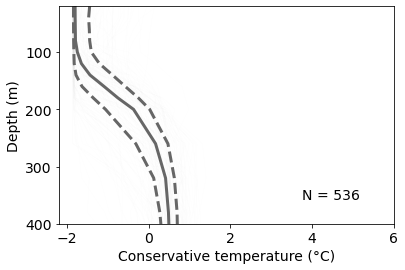

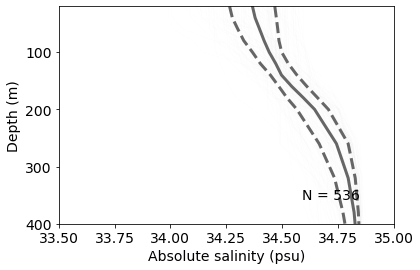

In [15]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==4, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='SON',
                                  withDensity=False)

## Calculate statistics over time 

### Tmax

analysis.calculate_stats_over_time
R-squared: 0.000608
slope (95%): -0.001086 +/- 0.022543


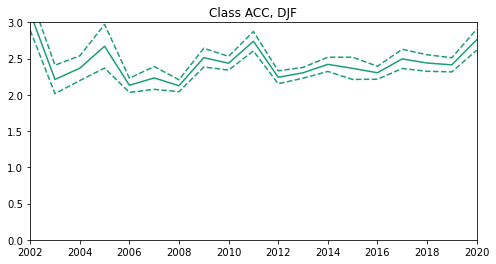

R-squared: 0.323544
slope (95%): 0.023090 +/- 0.017085


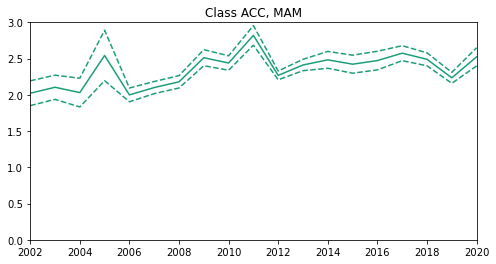

R-squared: 0.443914
slope (95%): 0.007470 +/- 0.004278


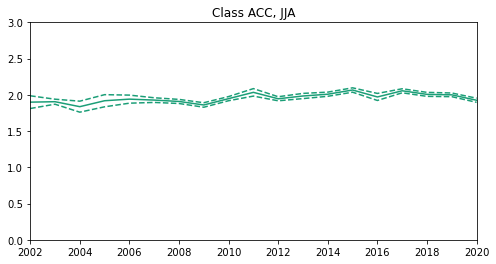

R-squared: 0.374047
slope (95%): 0.006065 +/- 0.004015


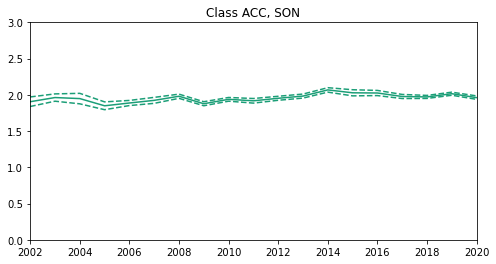

R-squared: 0.077335
slope (95%): 0.006567 +/- 0.011608


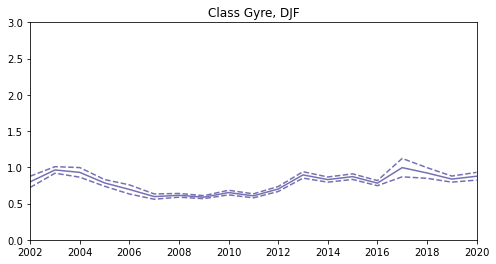

R-squared: 0.157760
slope (95%): 0.007425 +/- 0.008779


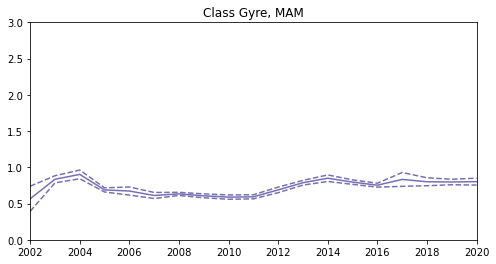

R-squared: 0.010149
slope (95%): 0.003029 +/- 0.015306


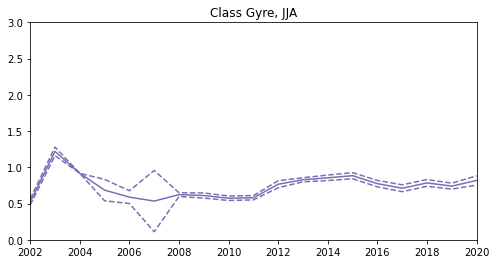

R-squared: 0.002502
slope (95%): 0.001332 +/- 0.014091


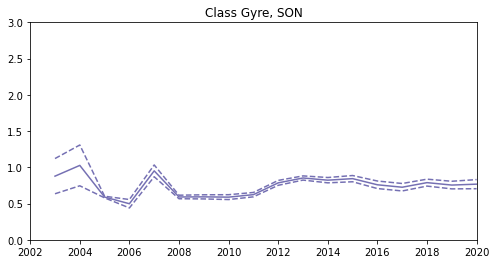

R-squared: 0.252536
slope (95%): 0.012497 +/- 0.011002


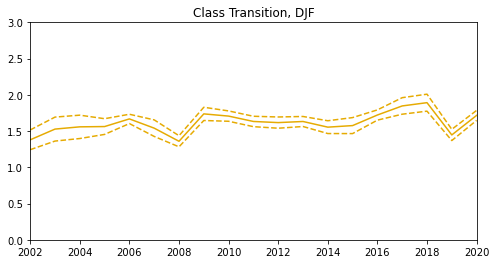

R-squared: 0.356005
slope (95%): 0.018155 +/- 0.012495


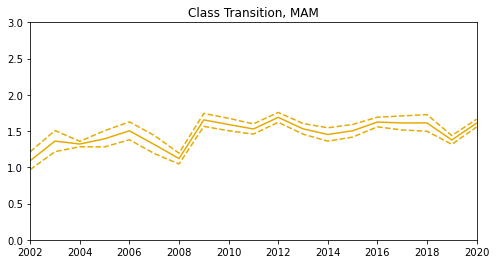

R-squared: 0.283514
slope (95%): 0.014626 +/- 0.011898


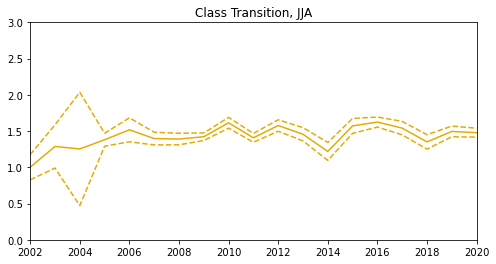

R-squared: 0.050636
slope (95%): 0.004391 +/- 0.010464


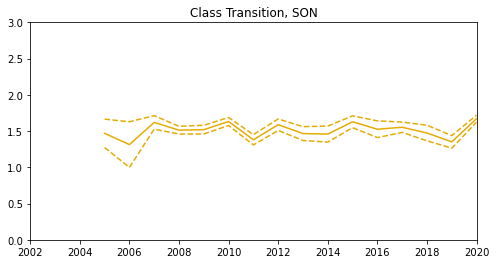

R-squared: 0.317909
slope (95%): 0.014742 +/- 0.011050


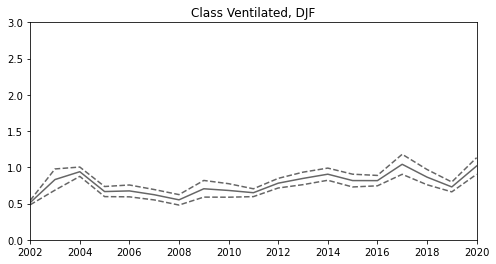

R-squared: 0.004507
slope (95%): 0.001236 +/- 0.009396


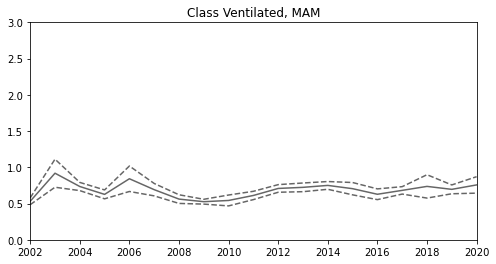

R-squared: 0.061306
slope (95%): 0.005943 +/- 0.011900


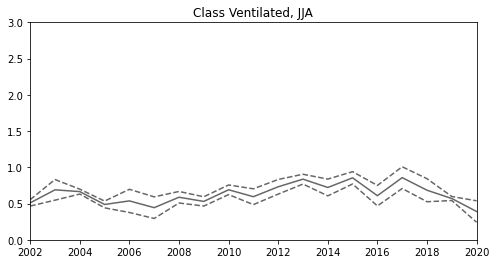

R-squared: 0.044777
slope (95%): -0.005321 +/- 0.013524


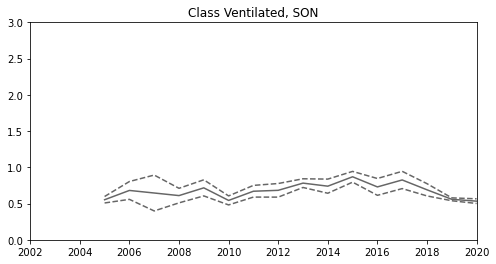

In [16]:
Tmax_mean, Tmax_std, Tmax_N, years = at.calculate_stats_over_time(dfp, varName='Tmax')
pt.plot_stats_from_analysis(ploc, dfp, Tmax_mean, Tmax_std, Tmax_N, years, colormap, n_components_selected, \
                            varName='Tmax', xlim=[2002, 2020], ylim=[0.0, 3.0])

### Tmin

analysis.calculate_stats_over_time
R-squared: 0.017331
slope (95%): -0.003674 +/- 0.014155


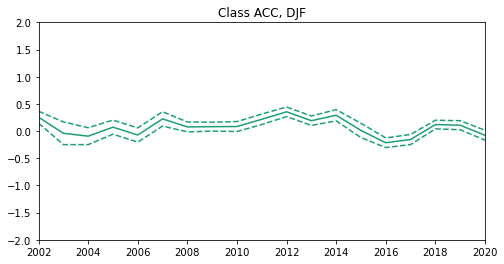

R-squared: 0.010865
slope (95%): 0.004257 +/- 0.020784


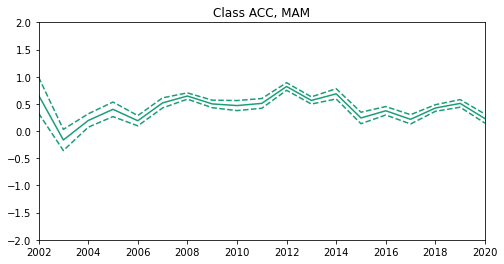

R-squared: 0.055139
slope (95%): 0.009553 +/- 0.020235


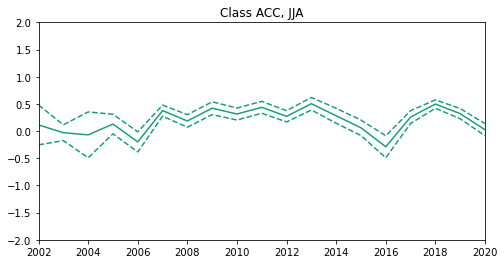

R-squared: 0.006064
slope (95%): 0.002554 +/- 0.016731


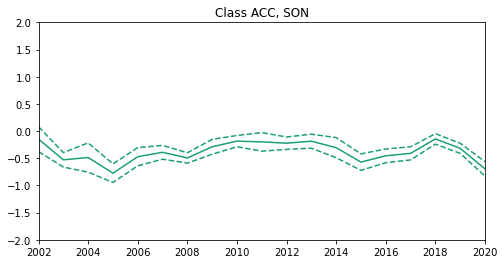

R-squared: 0.322271
slope (95%): 0.007004 +/- 0.005197


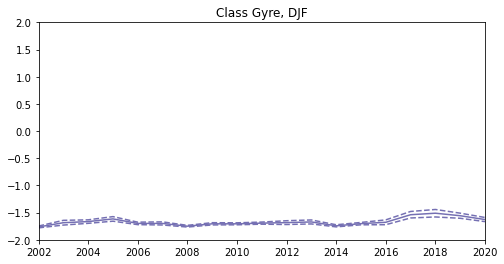

R-squared: 0.060780
slope (95%): 0.006625 +/- 0.013326


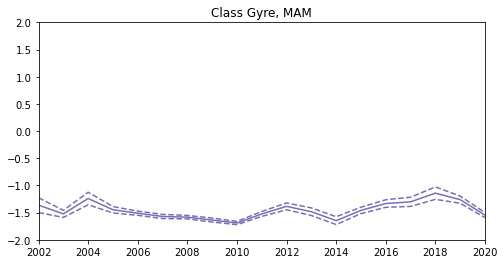

R-squared: 0.078946
slope (95%): -0.009361 +/- 0.016362


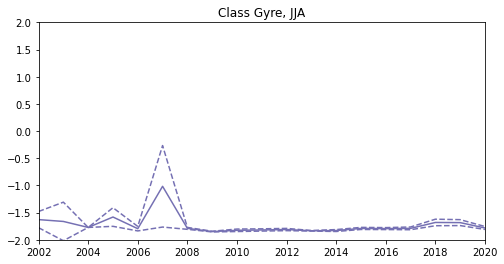

R-squared: 0.039322
slope (95%): -0.001221 +/- 0.003199


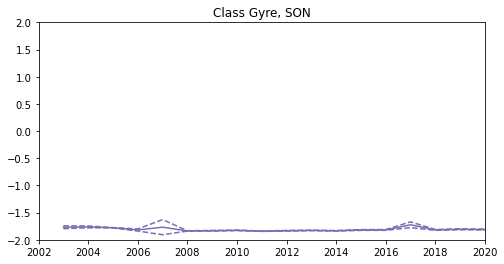

R-squared: 0.000795
slope (95%): 0.001209 +/- 0.021940


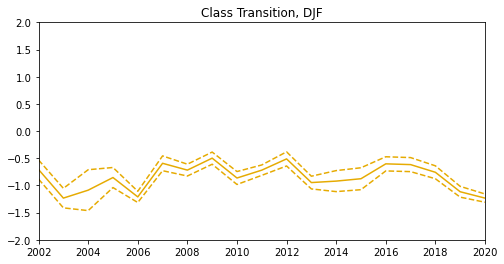

R-squared: 0.059780
slope (95%): 0.012865 +/- 0.026107


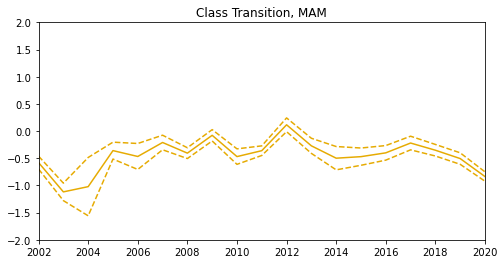

R-squared: 0.107914
slope (95%): -0.019503 +/- 0.028694


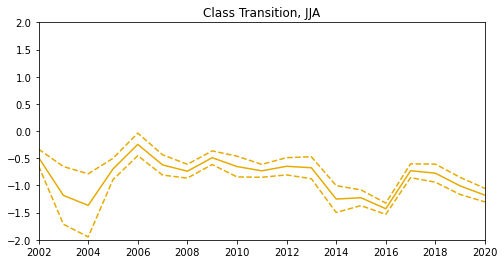

R-squared: 0.332622
slope (95%): -0.030250 +/- 0.023581


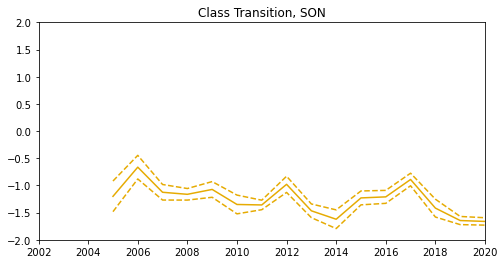

R-squared: 0.002983
slope (95%): -0.001135 +/- 0.010616


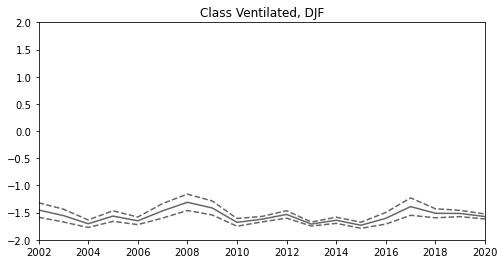

R-squared: 0.077161
slope (95%): 0.008995 +/- 0.015918


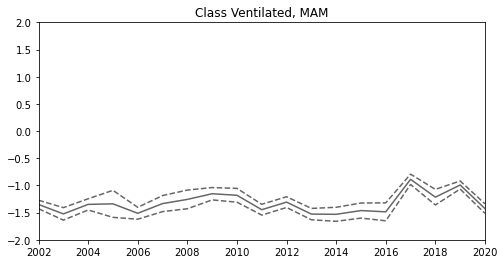

R-squared: 0.367763
slope (95%): -0.024284 +/- 0.016293


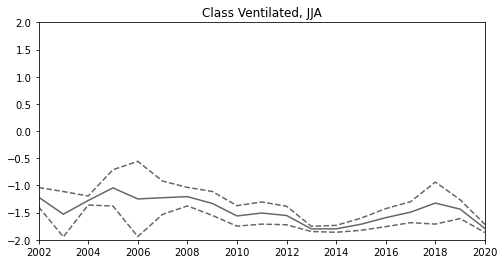

R-squared: 0.075914
slope (95%): -0.007933 +/- 0.015233


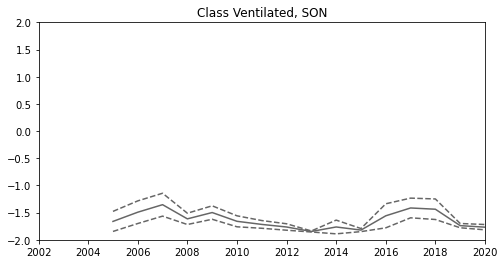

In [17]:
Tmin_mean, Tmin_std, Tmin_N, years = at.calculate_stats_over_time(dfp, varName='Tmin')
pt.plot_stats_from_analysis(ploc, dfp, Tmin_mean, Tmin_std, Tmin_N, years, colormap, n_components_selected, \
                            varName='Tmin', xlim=[2002, 2020], ylim=[-2.0, 2.0])

### Smax

analysis.calculate_stats_over_time
R-squared: 0.041039
slope (95%): 0.000185 +/- 0.000457


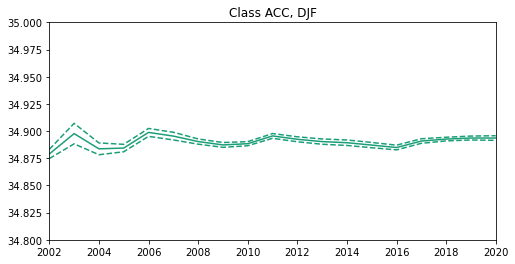

R-squared: 0.024882
slope (95%): 0.000166 +/- 0.000532


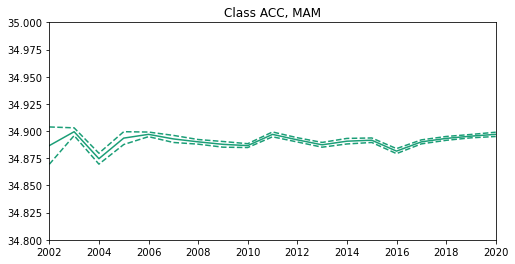

R-squared: 0.004815
slope (95%): 0.000076 +/- 0.000562


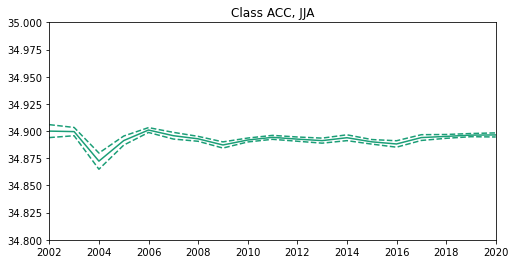

R-squared: 0.147011
slope (95%): -0.000399 +/- 0.000492


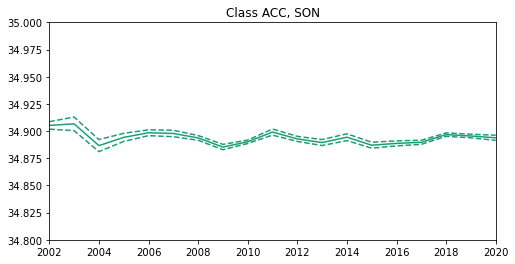

R-squared: 0.091539
slope (95%): -0.000132 +/- 0.000213


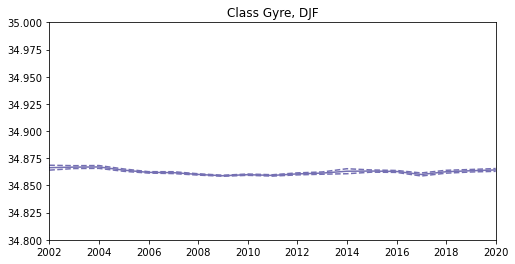

R-squared: 0.001161
slope (95%): -0.000016 +/- 0.000235


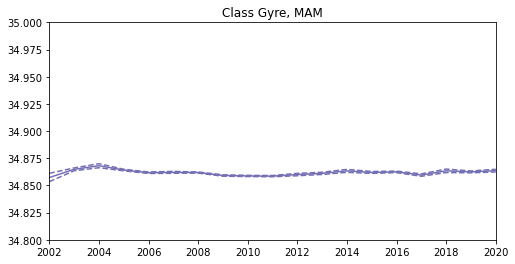

R-squared: 0.004696
slope (95%): -0.000064 +/- 0.000475


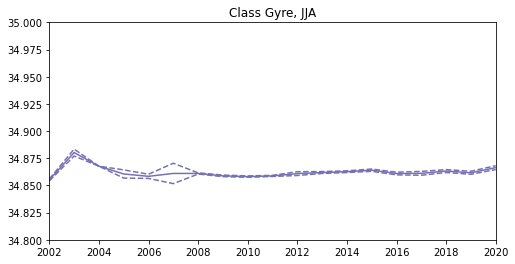

R-squared: 0.067579
slope (95%): -0.000201 +/- 0.000395


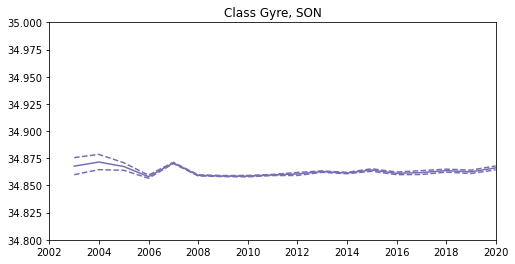

R-squared: 0.000024
slope (95%): 0.000005 +/- 0.000495


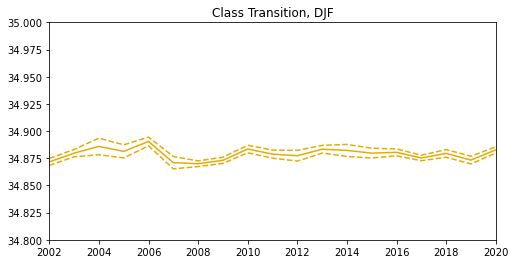

R-squared: 0.039156
slope (95%): 0.000217 +/- 0.000551


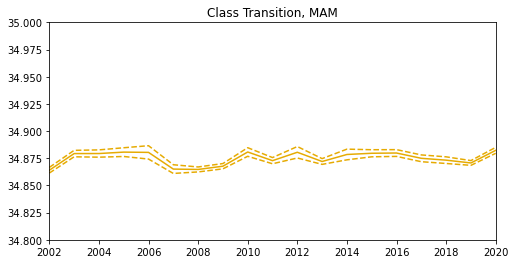

R-squared: 0.193781
slope (95%): 0.000413 +/- 0.000431


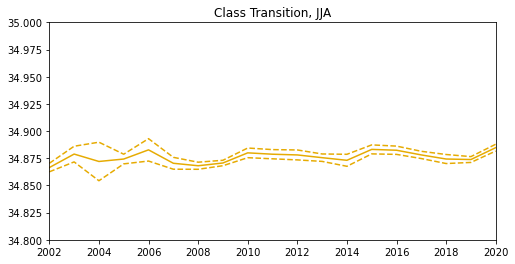

R-squared: 0.009822
slope (95%): 0.000126 +/- 0.000698


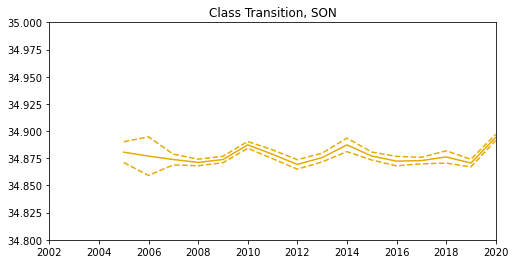

R-squared: 0.004769
slope (95%): -0.000046 +/- 0.000341


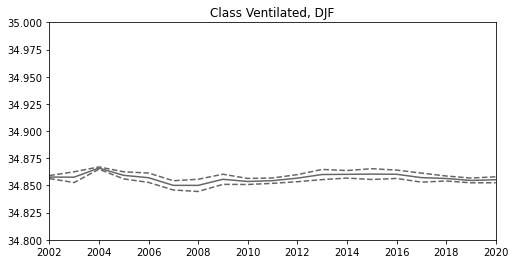

R-squared: 0.028300
slope (95%): -0.000138 +/- 0.000414


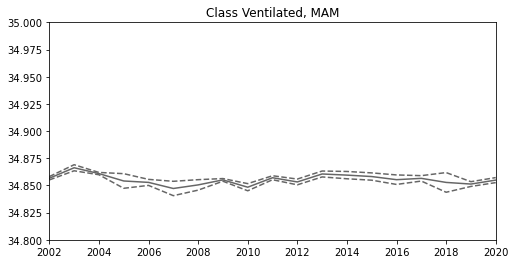

R-squared: 0.165035
slope (95%): -0.000426 +/- 0.000491


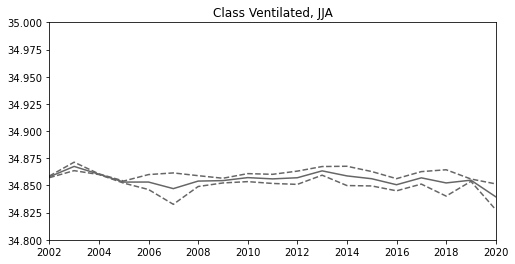

R-squared: 0.065854
slope (95%): -0.000351 +/- 0.000728


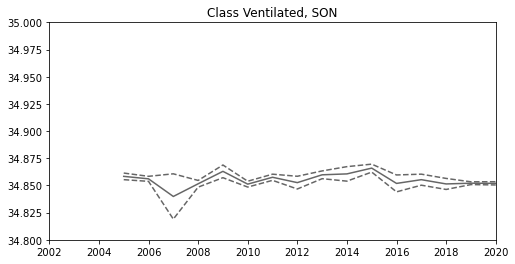

In [18]:
Smax_mean, Smax_std, Smax_N, years = at.calculate_stats_over_time(dfp, varName='Smax')
pt.plot_stats_from_analysis(ploc, dfp, Smax_mean, Smax_std, Smax_N, years, colormap, n_components_selected, \
                            varName='Smax', xlim=[2002, 2020], ylim=[34.8, 35.0])

### Smin

analysis.calculate_stats_over_time
R-squared: 0.000759
slope (95%): 0.000133 +/- 0.002464


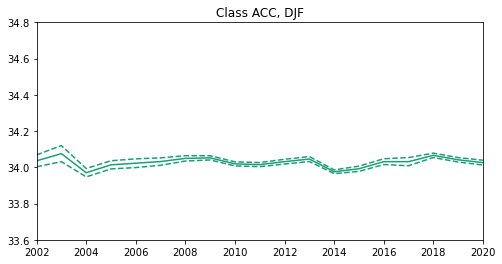

R-squared: 0.142134
slope (95%): -0.003031 +/- 0.003811


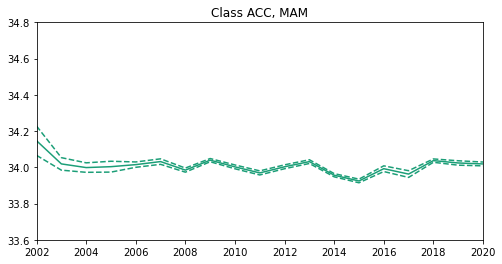

R-squared: 0.203711
slope (95%): -0.003881 +/- 0.003926


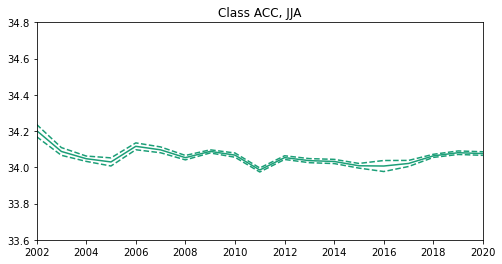

R-squared: 0.164287
slope (95%): -0.002856 +/- 0.003296


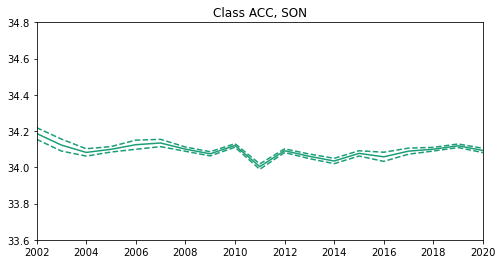

R-squared: 0.046368
slope (95%): -0.002279 +/- 0.005288


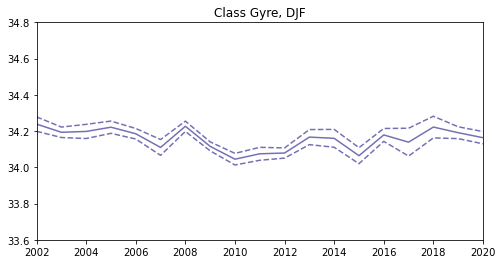

R-squared: 0.009783
slope (95%): 0.001197 +/- 0.006162


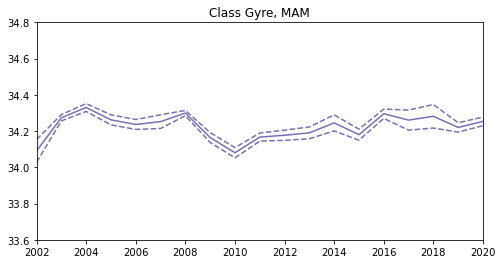

R-squared: 0.156417
slope (95%): 0.006718 +/- 0.007984


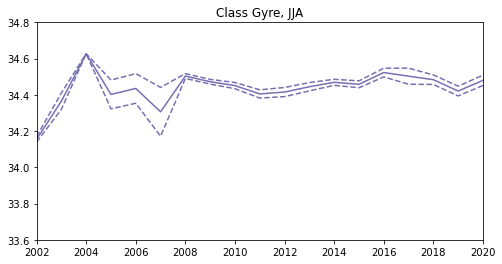

R-squared: 0.102351
slope (95%): -0.002413 +/- 0.003787


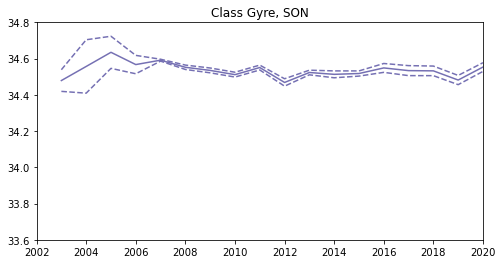

R-squared: 0.096006
slope (95%): -0.004159 +/- 0.006530


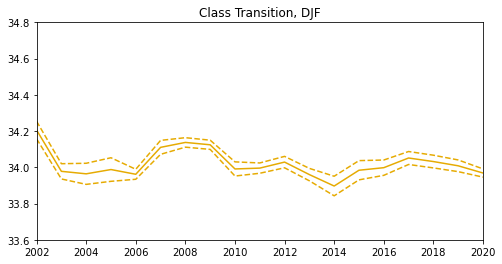

R-squared: 0.122746
slope (95%): -0.003542 +/- 0.004845


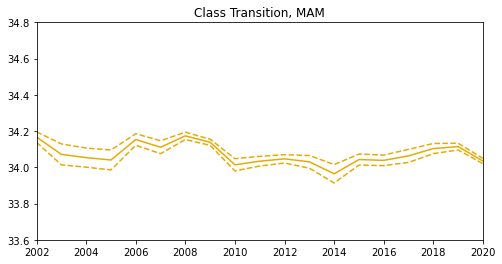

R-squared: 0.014468
slope (95%): 0.000996 +/- 0.004205


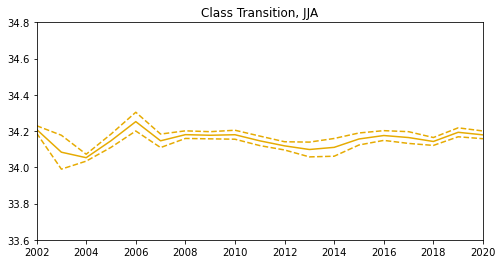

R-squared: 0.009931
slope (95%): 0.000884 +/- 0.004859


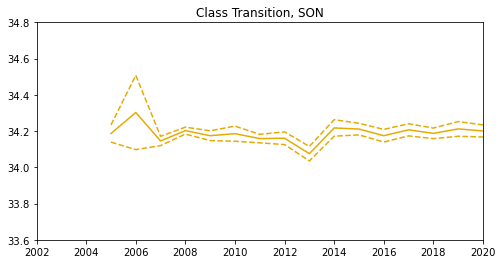

R-squared: 0.021768
slope (95%): -0.002735 +/- 0.009381


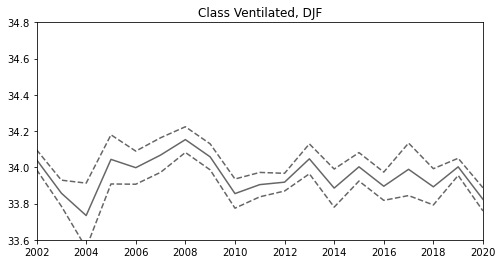

R-squared: 0.008650
slope (95%): -0.002032 +/- 0.011130


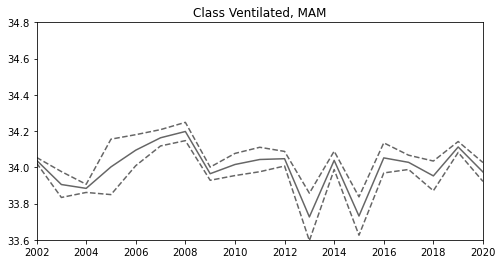

R-squared: 0.466105
slope (95%): 0.012400 +/- 0.006791


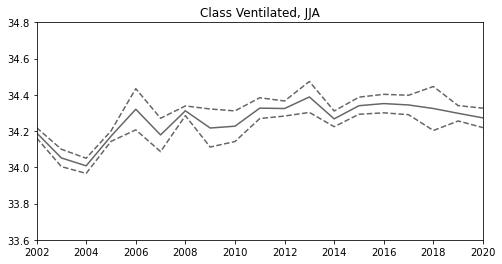

R-squared: 0.058608
slope (95%): 0.004152 +/- 0.009157


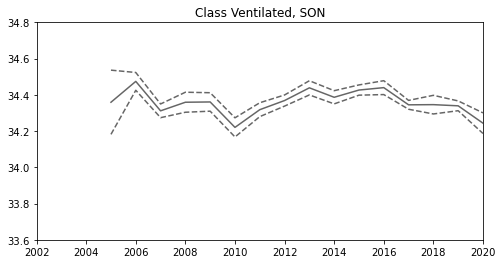

In [19]:
Smin_mean, Smin_std, Smin_N, years = at.calculate_stats_over_time(dfp, varName='Smin')
pt.plot_stats_from_analysis(ploc, dfp, Smin_mean, Smin_std, Smin_N, years, colormap, n_components_selected, \
                            varName='Smin', xlim=[2002,2020], ylim=[33.6, 34.8])

### MLD

analysis.calculate_stats_over_time
R-squared: 0.005130
slope (95%): 0.085538 +/- 0.609553


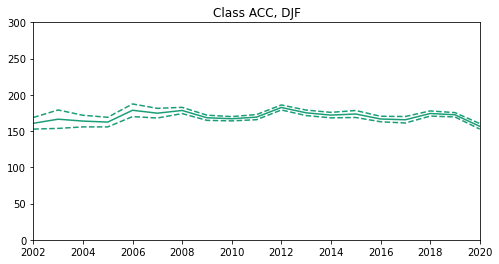

R-squared: 0.268159
slope (95%): -0.887040 +/- 0.749852


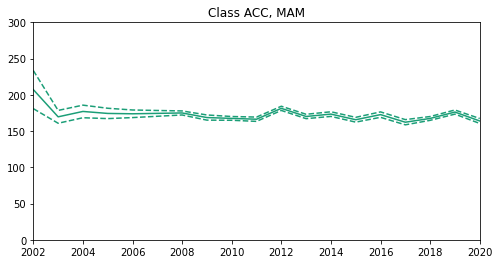

R-squared: 0.251801
slope (95%): -0.953448 +/- 0.841001


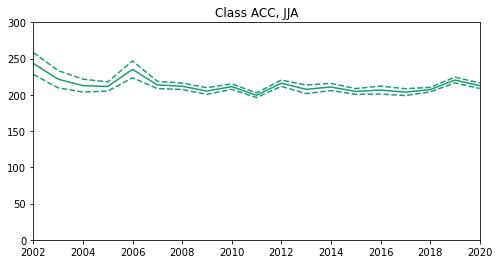

R-squared: 0.198961
slope (95%): -1.271729 +/- 1.305740


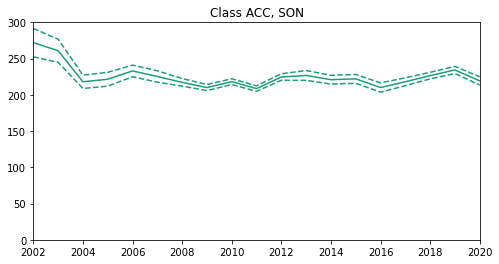

R-squared: 0.017787
slope (95%): -0.149605 +/- 0.568883


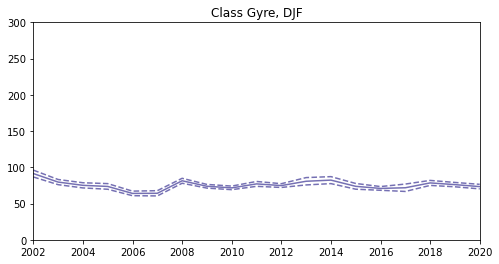

R-squared: 0.089935
slope (95%): -0.404747 +/- 0.658832


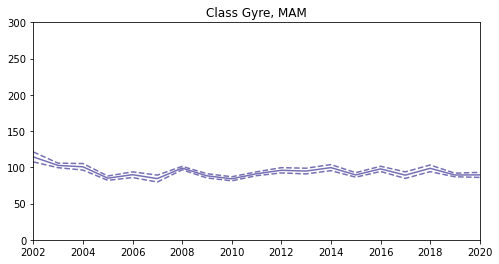

R-squared: 0.001538
slope (95%): -0.084045 +/- 1.095811


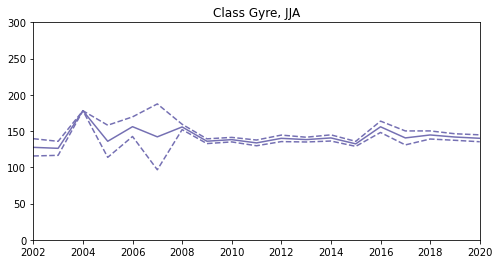

R-squared: 0.002394
slope (95%): 0.143016 +/- 1.547306


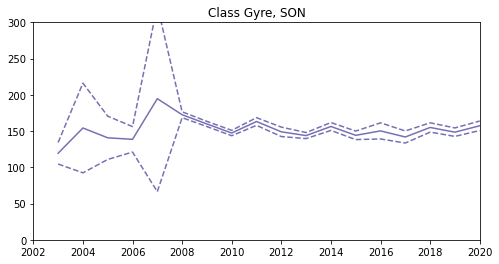

R-squared: 0.012157
slope (95%): -0.263389 +/- 1.214898


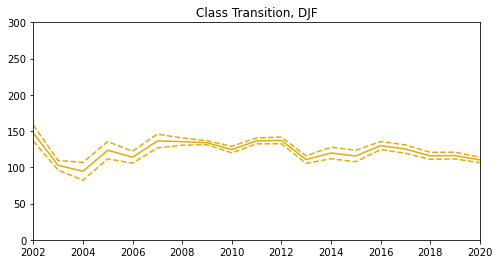

R-squared: 0.005038
slope (95%): -0.149579 +/- 1.075673


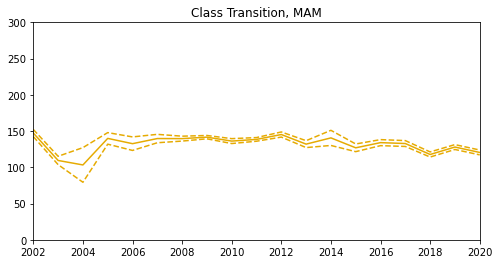

R-squared: 0.034806
slope (95%): -0.362604 +/- 0.977087


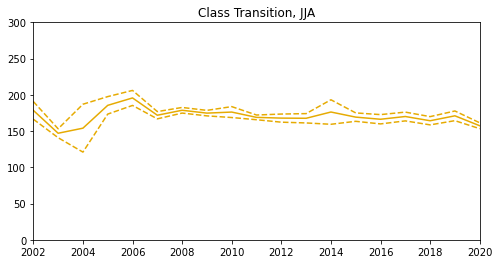

R-squared: 0.240942
slope (95%): -1.157309 +/- 1.130474


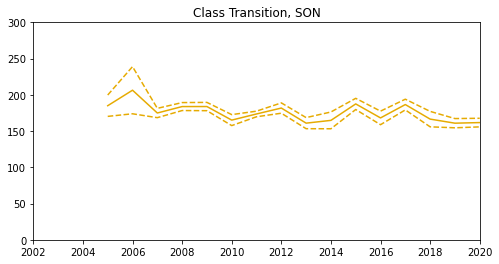

R-squared: 0.000005
slope (95%): -0.004019 +/- 0.950581


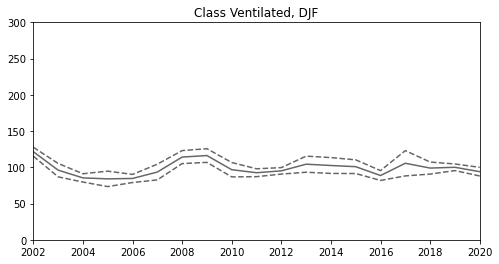

R-squared: 0.001369
slope (95%): -0.055886 +/- 0.772488


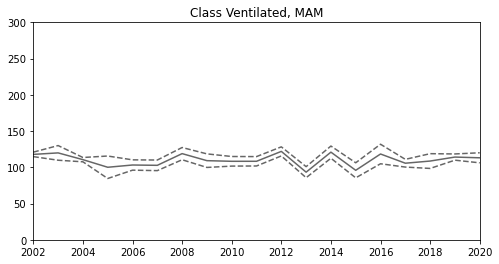

R-squared: 0.542263
slope (95%): 3.433731 +/- 1.614317


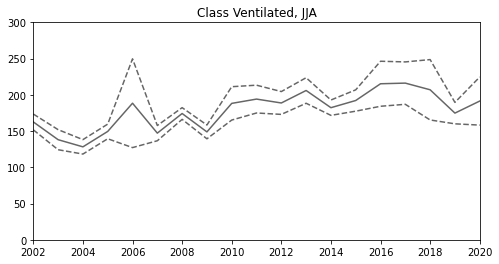

R-squared: 0.270685
slope (95%): 3.093195 +/- 2.794227


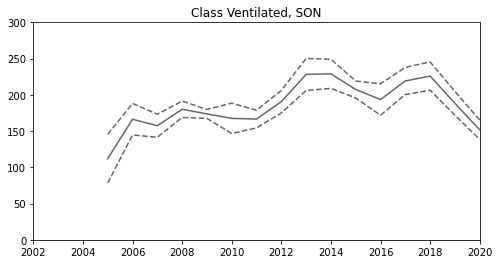

In [20]:
mld_mean, mld_std, mld_N, years = at.calculate_stats_over_time(dfp, varName='mld')
pt.plot_stats_from_analysis(ploc, dfp, mld_mean, mld_std, mld_N, years, colormap, n_components_selected, \
                            varName='mld', xlim=[2002,2020], ylim=[0,300])

### Near-surface stratification

analysis.calculate_stats_over_time
R-squared: 0.355191
slope (95%): -0.000000 +/- 0.000000


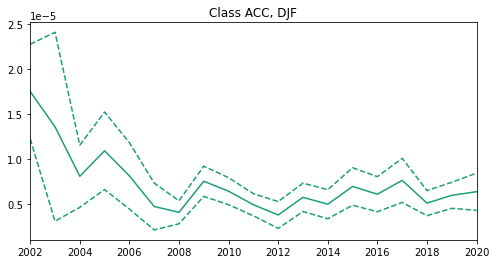

R-squared: 0.036048
slope (95%): 0.000000 +/- 0.000000


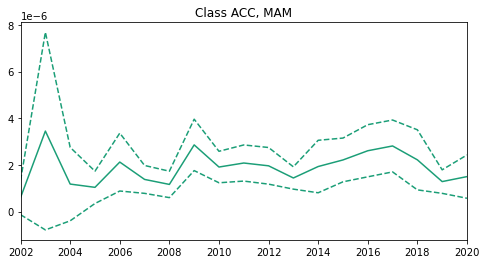

R-squared: 0.099448
slope (95%): 0.000000 +/- 0.000000


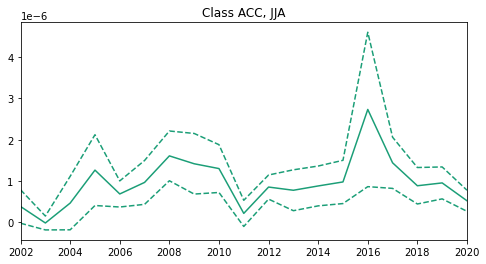

R-squared: 0.182704
slope (95%): 0.000000 +/- 0.000000


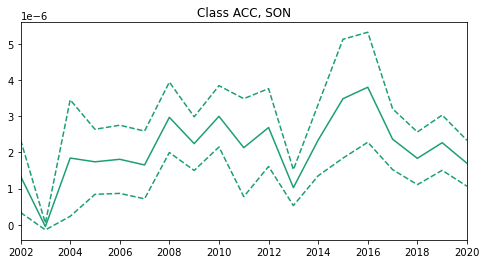

R-squared: 0.000917
slope (95%): -0.000000 +/- 0.000002


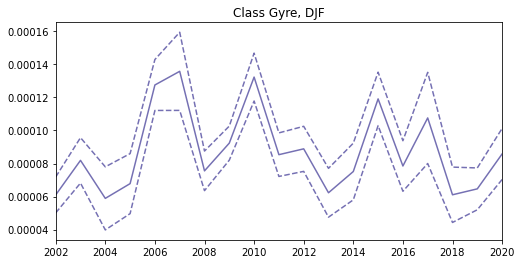

R-squared: 0.001215
slope (95%): -0.000000 +/- 0.000001


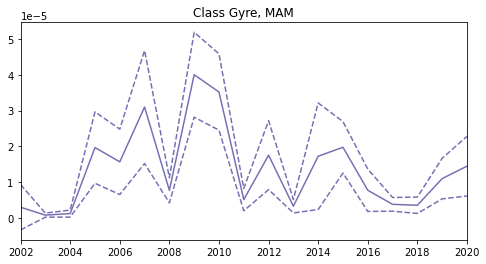

R-squared: 0.069363
slope (95%): -0.000000 +/- 0.000000


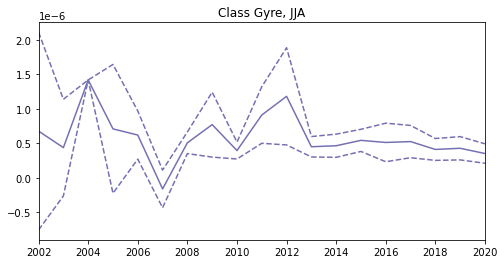

R-squared: 0.011575
slope (95%): -0.000000 +/- 0.000000


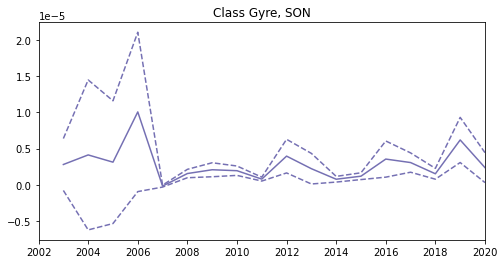

R-squared: 0.001039
slope (95%): 0.000000 +/- 0.000002


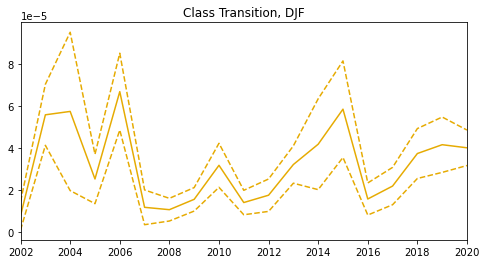

R-squared: 0.024322
slope (95%): 0.000000 +/- 0.000000


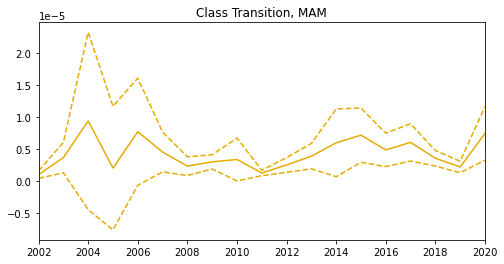

R-squared: 0.142521
slope (95%): 0.000000 +/- 0.000000


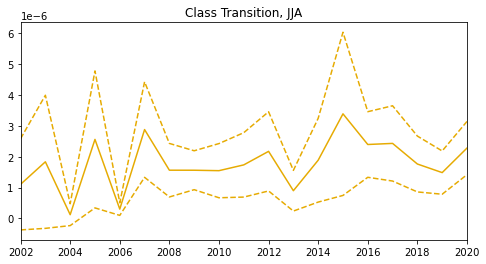

R-squared: 0.031876
slope (95%): -0.000000 +/- 0.000000


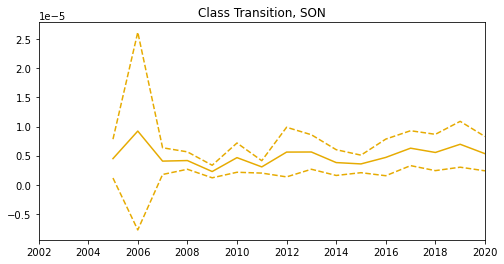

R-squared: 0.000268
slope (95%): 0.000000 +/- 0.000003


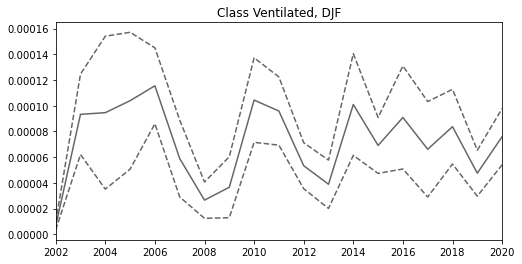

R-squared: 0.025711
slope (95%): -0.000000 +/- 0.000001


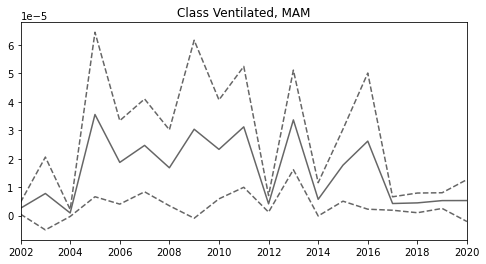

R-squared: 0.022985
slope (95%): 0.000000 +/- 0.000000


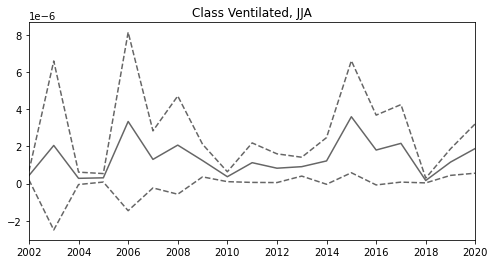

R-squared: 0.227193
slope (95%): -0.000000 +/- 0.000000


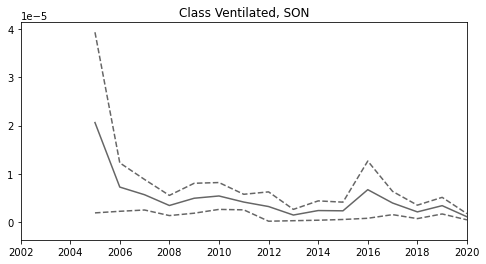

In [21]:
N2_mean, N2_std, N2_N, years = at.calculate_stats_over_time(dfp, varName='Nsquared_surface')
pt.plot_stats_from_analysis(ploc, dfp, N2_mean, N2_std, N2_N, years, colormap, n_components_selected, \
                            varName='Nsquared_surface', xlim=[2002,2020])

### Depth of temperature maximum

analysis.calculate_stats_over_time
R-squared: 0.036812
slope (95%): -1.600197 +/- 4.188440


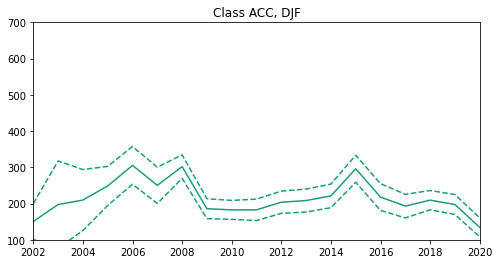

R-squared: 0.353441
slope (95%): -6.338789 +/- 4.387046


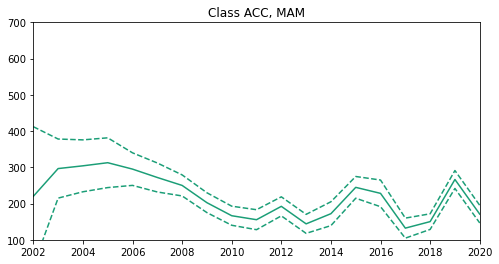

R-squared: 0.490724
slope (95%): -4.887292 +/- 2.547690


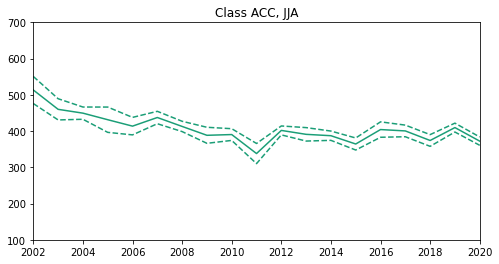

R-squared: 0.523641
slope (95%): -4.613951 +/- 2.251872


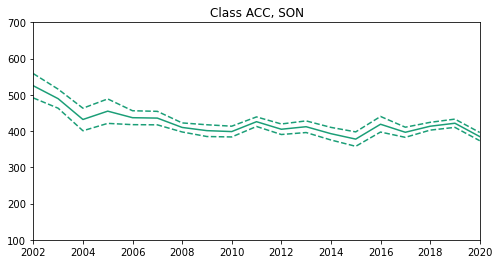

R-squared: 0.085713
slope (95%): -3.003027 +/- 5.018758


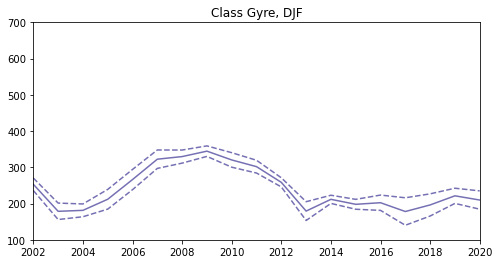

R-squared: 0.038779
slope (95%): -1.583733 +/- 4.034732


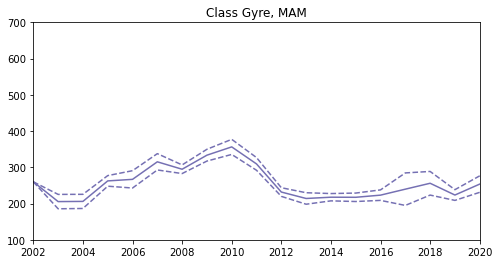

R-squared: 0.000600
slope (95%): -0.229974 +/- 4.802444


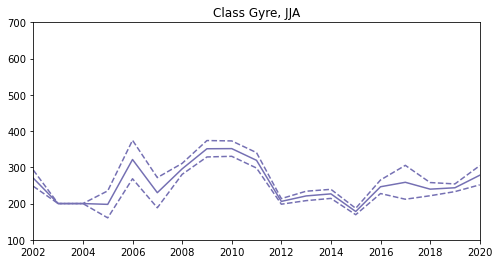

R-squared: 0.044806
slope (95%): -2.598700 +/- 6.359038


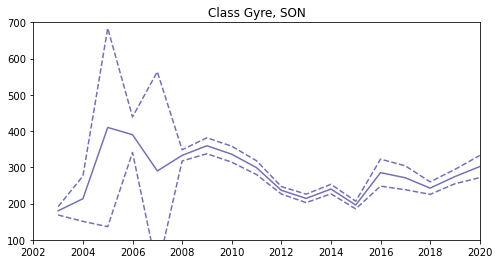

R-squared: 0.139587
slope (95%): -3.057509 +/- 3.884348


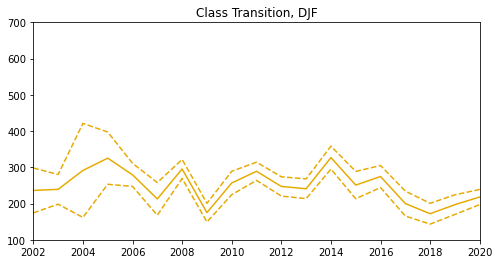

R-squared: 0.019229
slope (95%): -1.175382 +/- 4.295384


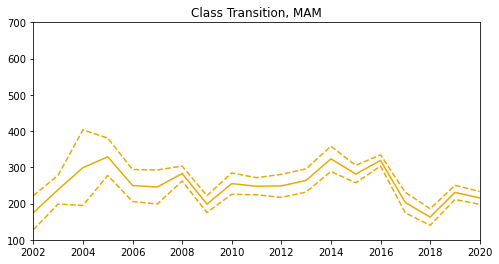

R-squared: 0.106620
slope (95%): -1.488133 +/- 2.204247


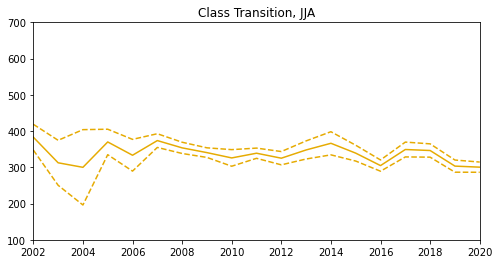

R-squared: 0.366068
slope (95%): -3.043043 +/- 2.203831


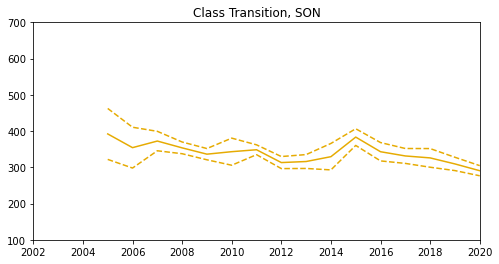

R-squared: 0.022567
slope (95%): -2.248929 +/- 7.573609


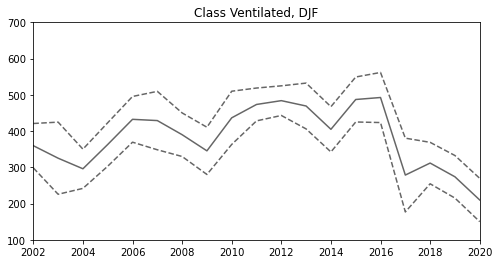

R-squared: 0.094144
slope (95%): 5.167746 +/- 8.202662


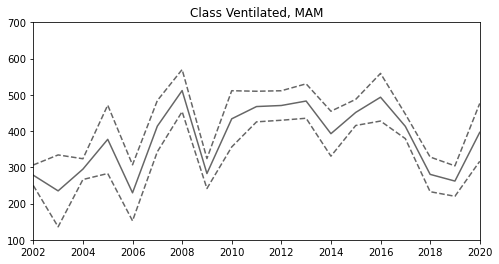

R-squared: 0.445658
slope (95%): 10.054463 +/- 5.738080


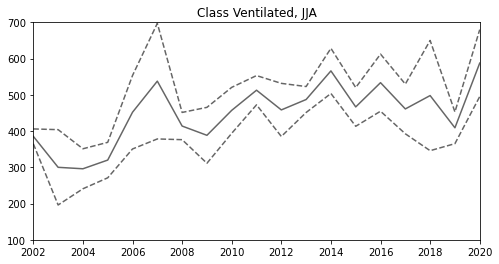

R-squared: 0.025439
slope (95%): -1.470720 +/- 5.009767


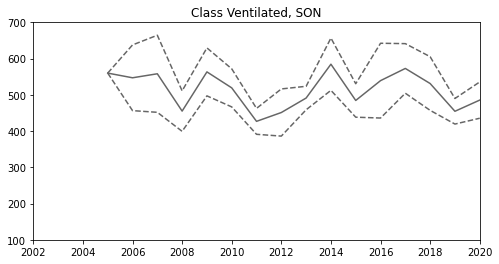

In [22]:
Tmaxd_mean, Tmaxd_std, Tmaxd_N, years = at.calculate_stats_over_time(dfp, varName='Tmax_depth')
pt.plot_stats_from_analysis(ploc, dfp, Tmaxd_mean, Tmaxd_std, Tmaxd_N, years, colormap, n_components_selected, 
                            varName='Tmax_depth', xlim=[2002, 2020], ylim=[100,700])

### Depth of temperature minimum

analysis.calculate_stats_over_time
R-squared: 0.006397
slope (95%): -0.092127 +/- 0.587527


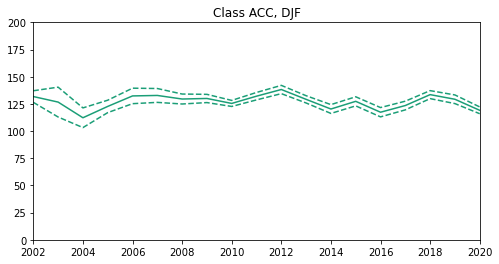

R-squared: 0.160820
slope (95%): -0.825380 +/- 0.964786


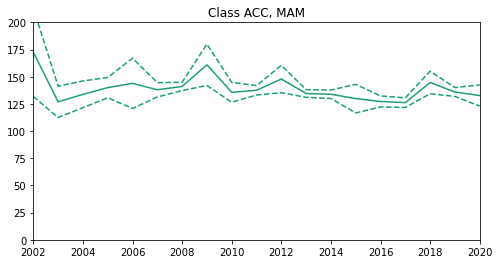

R-squared: 0.041039
slope (95%): 0.494457 +/- 1.223070


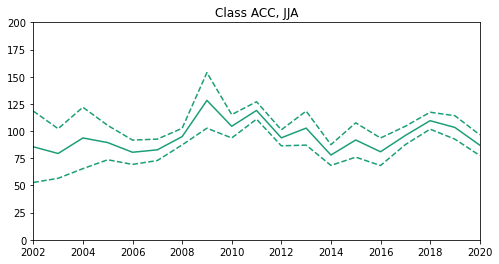

R-squared: 0.029372
slope (95%): 0.290269 +/- 0.853850


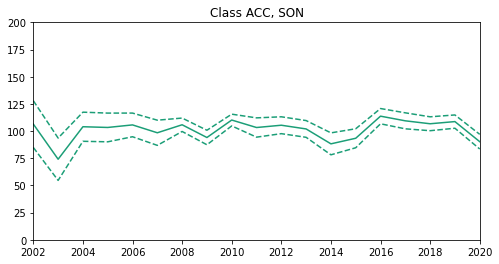

R-squared: 0.022119
slope (95%): -0.128031 +/- 0.435605


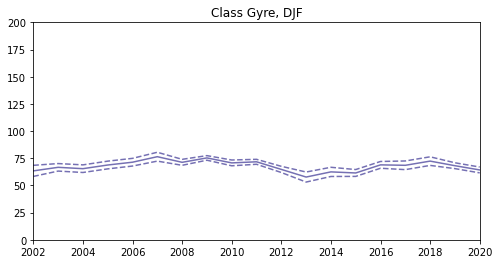

R-squared: 0.134778
slope (95%): -0.533744 +/- 0.692002


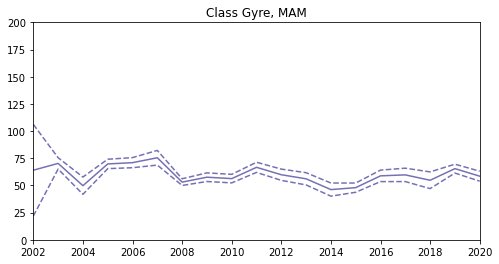

R-squared: 0.001994
slope (95%): -0.040122 +/- 0.459321


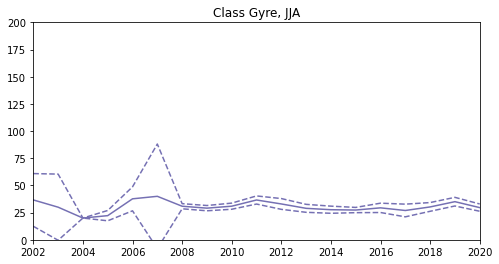

R-squared: 0.115696
slope (95%): -0.336629 +/- 0.493231


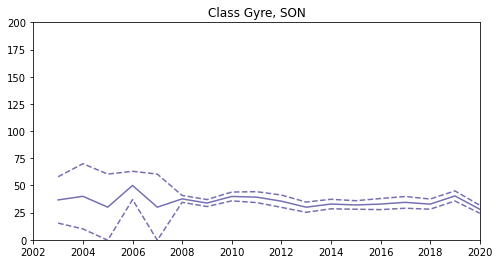

R-squared: 0.018794
slope (95%): -0.451623 +/- 1.669830


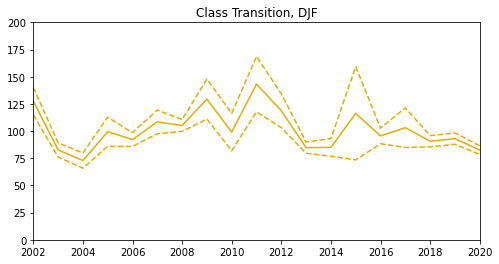

R-squared: 0.004418
slope (95%): 0.545559 +/- 4.190743


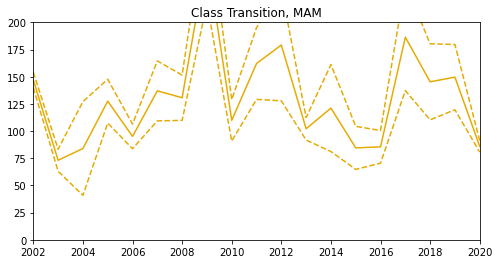

R-squared: 0.157946
slope (95%): -1.659413 +/- 1.960603


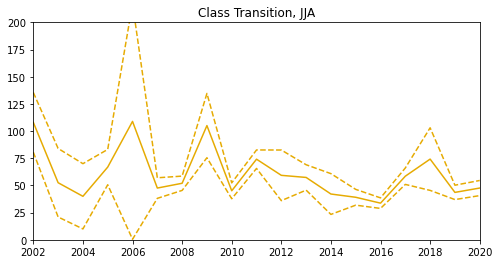

R-squared: 0.052436
slope (95%): -0.694724 +/- 1.625284


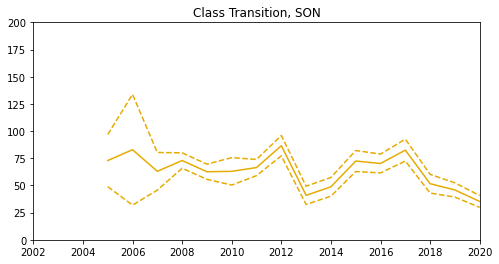

R-squared: 0.042572
slope (95%): -0.544186 +/- 1.320570


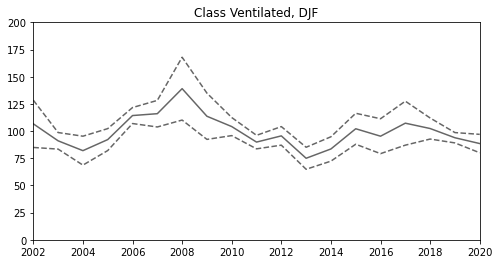

R-squared: 0.031607
slope (95%): -0.649453 +/- 1.839496


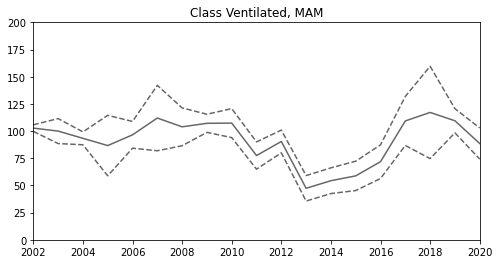

R-squared: 0.188793
slope (95%): -0.805734 +/- 0.854644


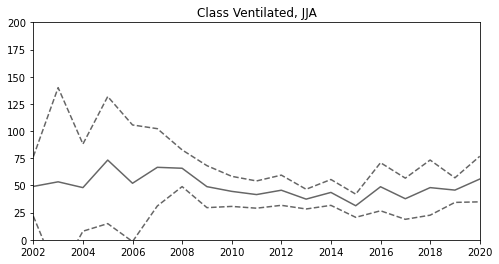

R-squared: 0.124930
slope (95%): -1.606761 +/- 2.340284


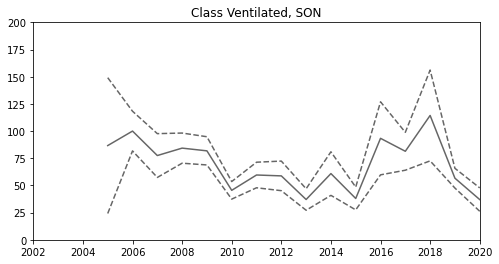

In [23]:
Tmind_mean, Tmind_std, Tmind_N, years = at.calculate_stats_over_time(dfp, varName='Tmin_depth')
pt.plot_stats_from_analysis(ploc, dfp, Tmind_mean, Tmind_std, Tmind_N, years, colormap, n_components_selected, \
                            varName='Tmin_depth', xlim=[2002, 2020], ylim=[0, 200])

### CT, SA, and depth of sig0=27.4 surface 

CONSERVATIVE TEMPERATURE
analysis.calculate_stats_over_time
R-squared: 0.001957
slope (95%): 0.001390 +/- 0.016639


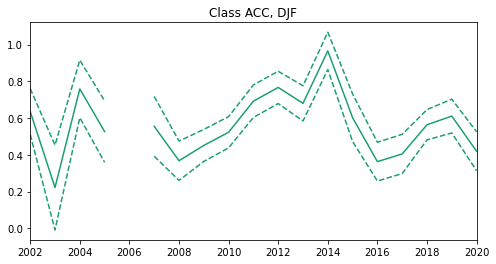

R-squared: 0.115993
slope (95%): 0.014228 +/- 0.020098


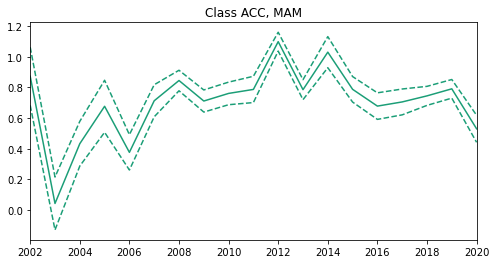

R-squared: 0.251954
slope (95%): 0.016497 +/- 0.018864


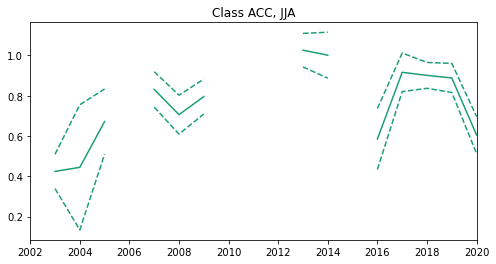

R-squared: 0.102784
slope (95%): 0.016841 +/- 0.044471


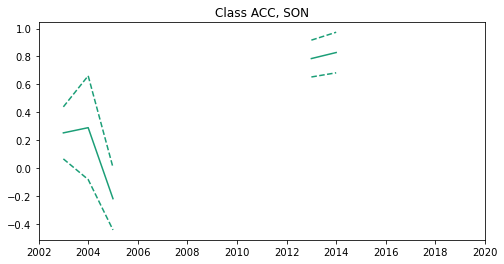

plot_tools:plot_simple_linear_regression: cannot regress empty array


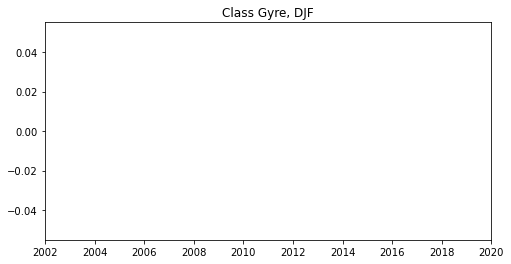

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


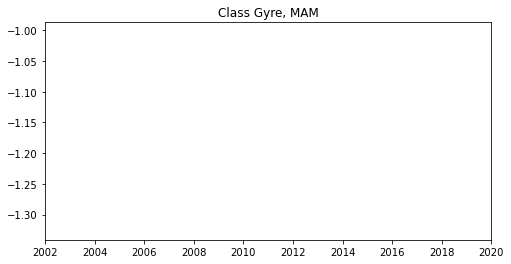

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


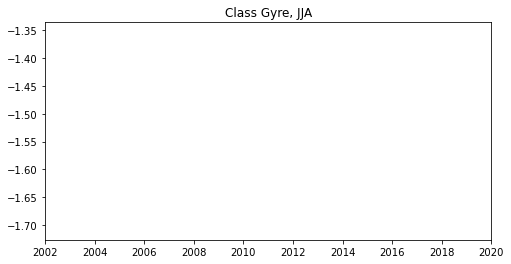

plot_tools:plot_simple_linear_regression: cannot regress empty array


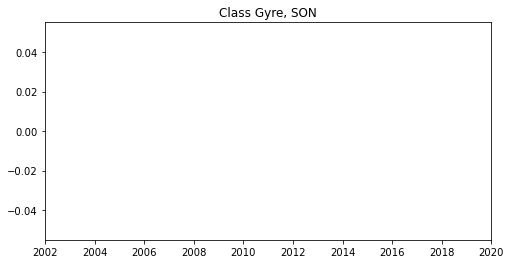

R-squared: 0.615351
slope (95%): 0.043065 +/- 0.103590


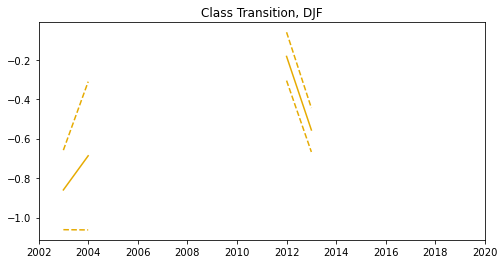

R-squared: 0.192557
slope (95%): 0.045159 +/- 1.174994


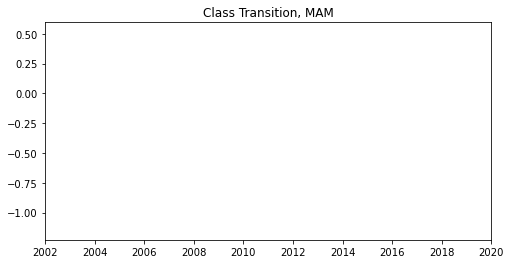

R-squared: 0.000000
slope (95%): nan +/- nan


/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


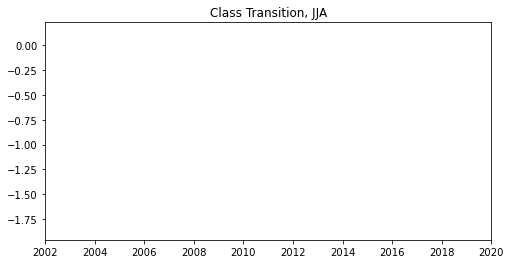

plot_tools:plot_simple_linear_regression: cannot regress empty array


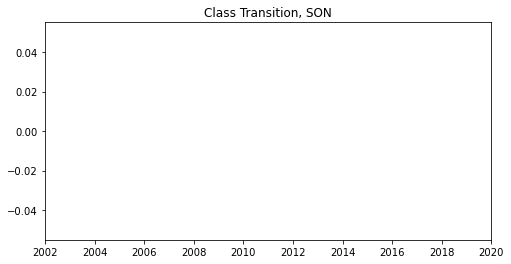

plot_tools:plot_simple_linear_regression: cannot regress empty array


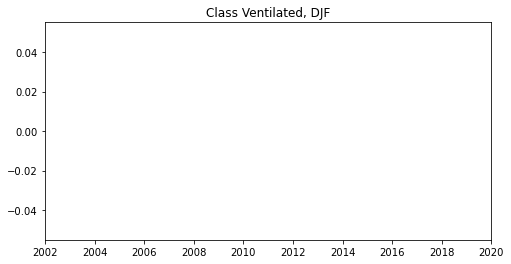

R-squared: 0.458091
slope (95%): 0.046886 +/- 0.155151


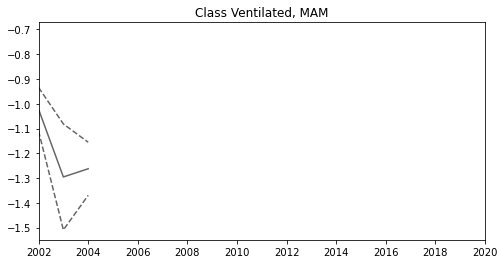

R-squared: 0.983287
slope (95%): 0.214918 +/- 0.356025


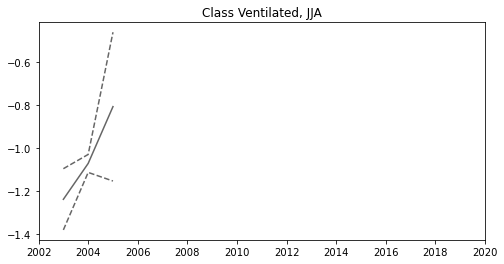

plot_tools:plot_simple_linear_regression: cannot regress empty array


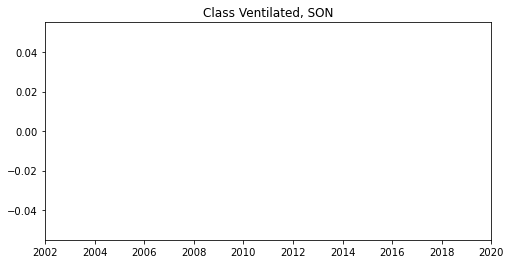

ABSOLUTE SALINITY
analysis.calculate_stats_over_time
R-squared: 0.005520
slope (95%): 0.000174 +/- 0.001238


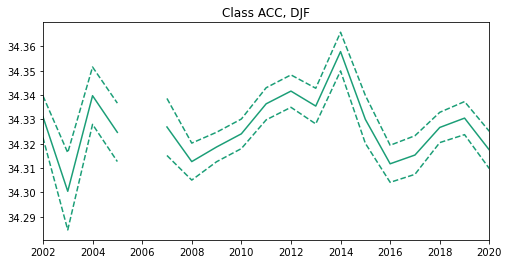

R-squared: 0.121462
slope (95%): 0.001082 +/- 0.001489


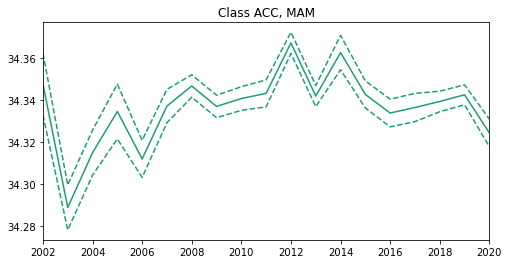

R-squared: 0.272527
slope (95%): 0.001324 +/- 0.001436


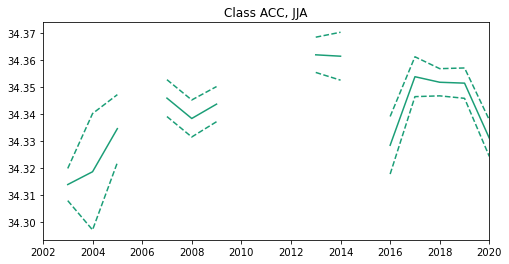

R-squared: 0.118345
slope (95%): 0.001255 +/- 0.003062


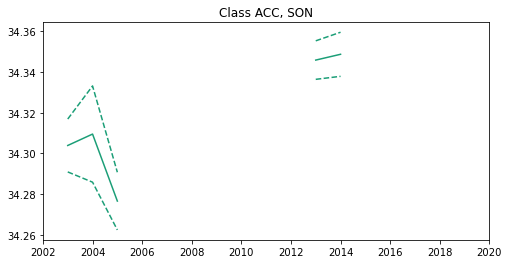

plot_tools:plot_simple_linear_regression: cannot regress empty array


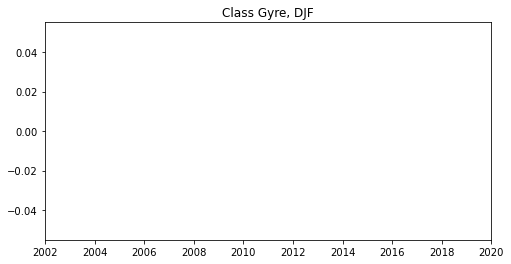

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


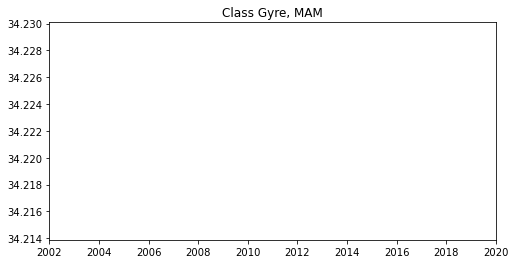

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


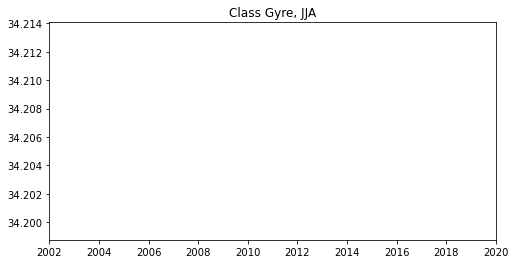

plot_tools:plot_simple_linear_regression: cannot regress empty array


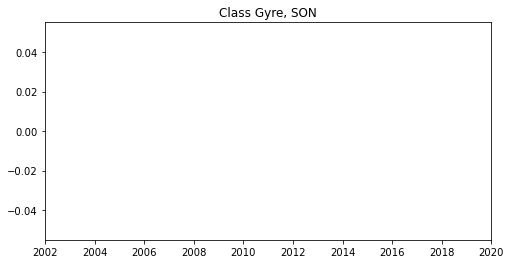

R-squared: 0.548208
slope (95%): 0.002170 +/- 0.005993


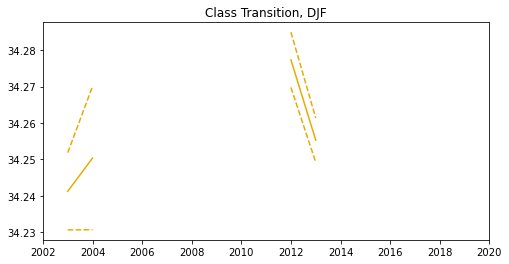

R-squared: 0.204637
slope (95%): 0.002730 +/- 0.068384


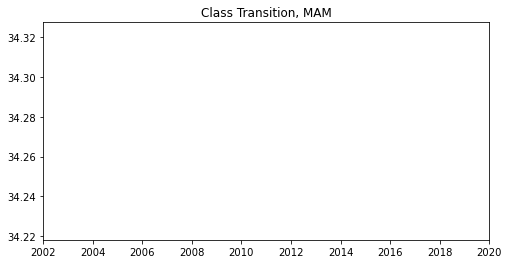

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


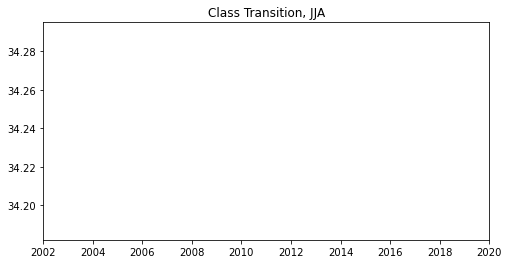

plot_tools:plot_simple_linear_regression: cannot regress empty array


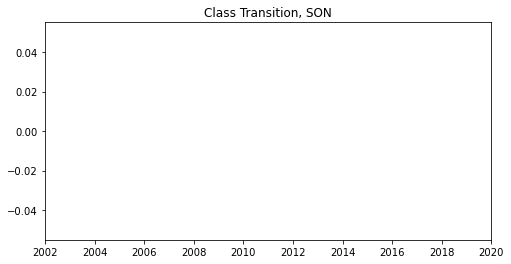

plot_tools:plot_simple_linear_regression: cannot regress empty array


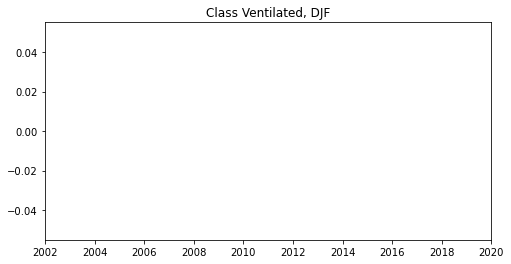

R-squared: 0.482584
slope (95%): 0.002261 +/- 0.007122


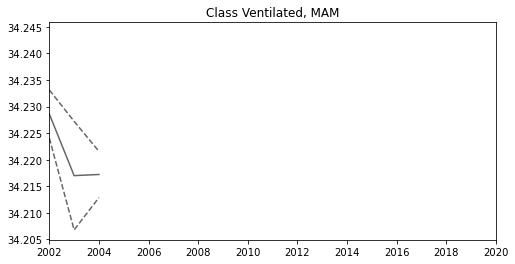

R-squared: 0.969688
slope (95%): 0.010398 +/- 0.023360


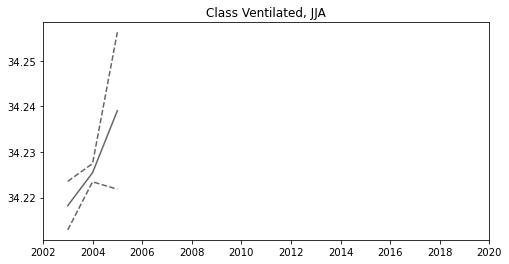

plot_tools:plot_simple_linear_regression: cannot regress empty array


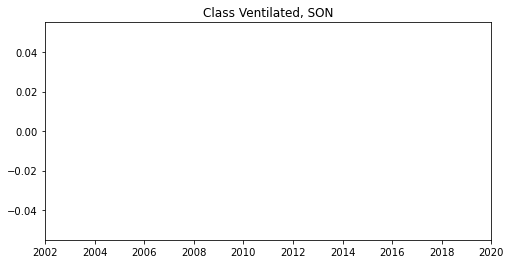

DEPTH OF SURFACE
analysis.calculate_stats_over_time
R-squared: 0.001855
slope (95%): 0.048324 +/- 0.594095


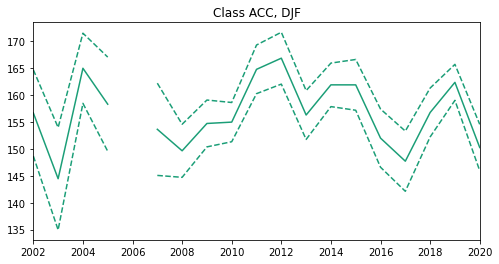

R-squared: 0.017863
slope (95%): 0.173696 +/- 0.659058


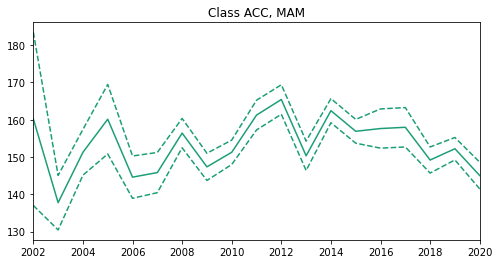

R-squared: 0.003487
slope (95%): -0.042337 +/- 0.474969


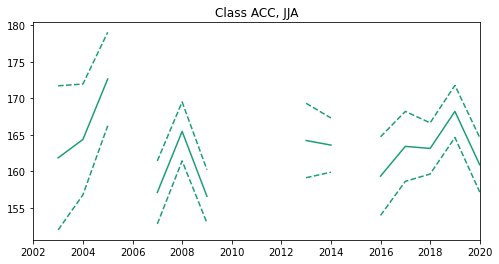

R-squared: 0.100594
slope (95%): -0.445629 +/- 1.190908


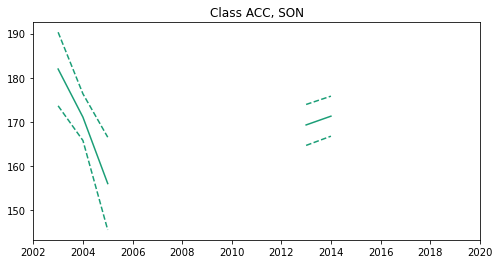

plot_tools:plot_simple_linear_regression: cannot regress empty array


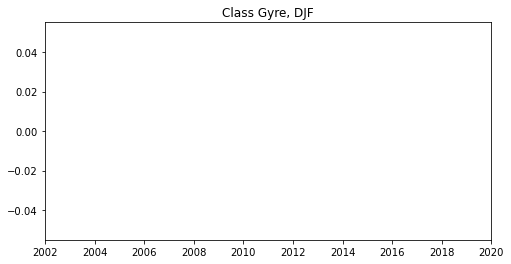

R-squared: 0.000000
slope (95%): nan +/- nan


/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


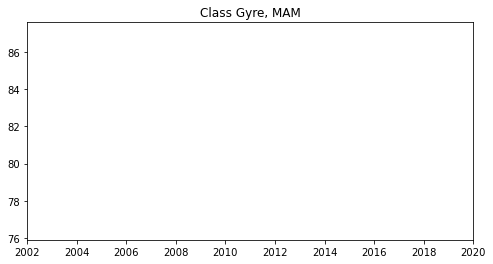

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


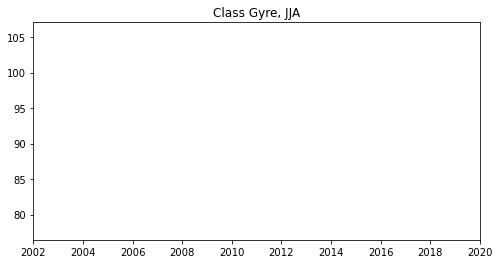

plot_tools:plot_simple_linear_regression: cannot regress empty array


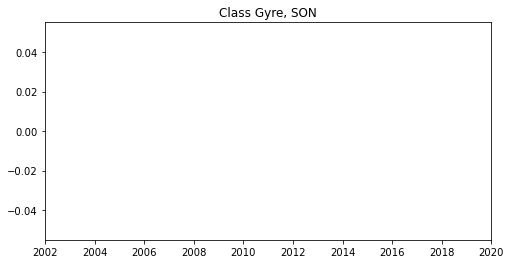

R-squared: 0.699184
slope (95%): 2.839905 +/- 5.667354


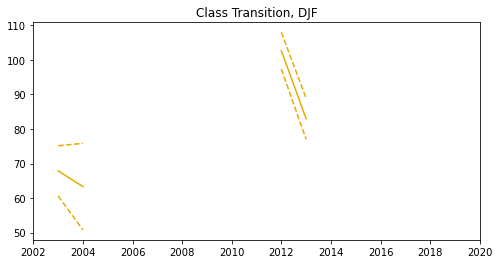

R-squared: 0.129890
slope (95%): 1.533796 +/- 50.440982


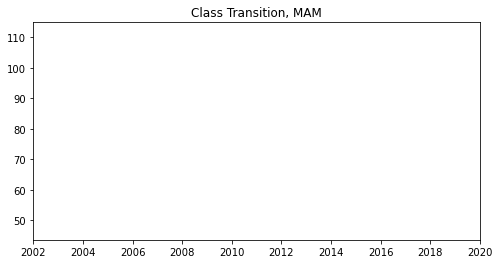

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


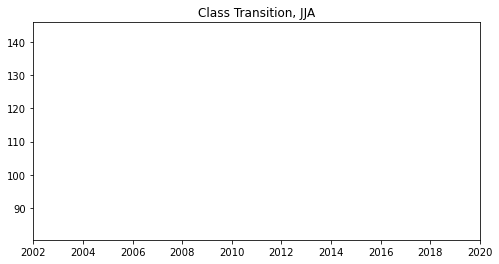

plot_tools:plot_simple_linear_regression: cannot regress empty array


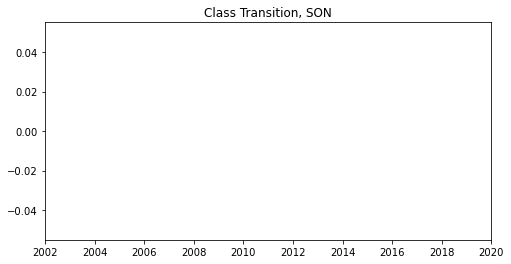

plot_tools:plot_simple_linear_regression: cannot regress empty array


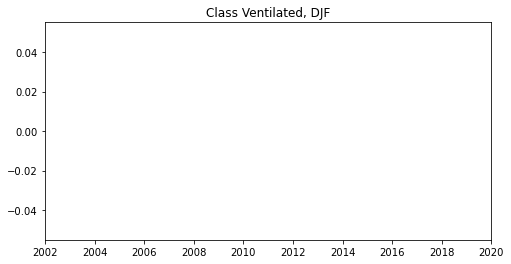

R-squared: 0.005860
slope (95%): 0.053775 +/- 2.130969


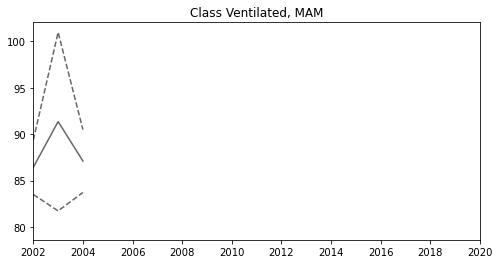

R-squared: 0.557234
slope (95%): 4.980911 +/- 56.414743


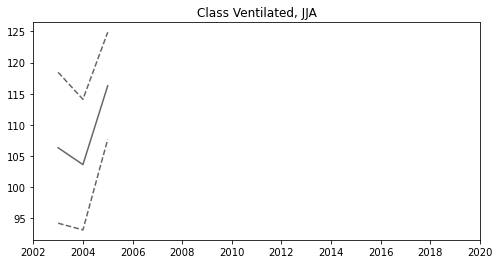

plot_tools:plot_simple_linear_regression: cannot regress empty array


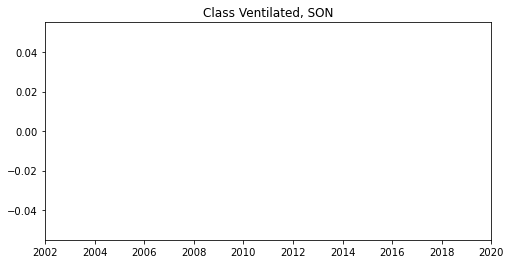

In [24]:
print("CONSERVATIVE TEMPERATURE")
ct274_mean, ct274_std, ct274_N, years = at.calculate_stats_over_time(dfp, varName='ct_on_sig0', sig0index=0)
pt.plot_stats_from_analysis(ploc, dfp, ct274_mean, ct274_std, ct274_N, years, colormap, n_components_selected, \
                            varName='ct274', xlim=[2002, 2020])

print("ABSOLUTE SALINITY")
sa274_mean, sa274_std, sa274_N, years = at.calculate_stats_over_time(dfp, varName='sa_on_sig0', sig0index=0)
pt.plot_stats_from_analysis(ploc, dfp, sa274_mean, sa274_std, sa274_N, years, colormap, n_components_selected, \
                            varName='sa274', xlim=[2002, 2020])

print("DEPTH OF SURFACE")
z274_mean, z274_std, z274_N, years = at.calculate_stats_over_time(dfp, varName='z_on_sig0', sig0index=0)
pt.plot_stats_from_analysis(ploc, dfp, z274_mean, z274_std, z274_N, years, colormap, n_components_selected, \
                            varName='z274', xlim=[2002, 2020])

### CT, SA, and depth of sig0=27.6 surface 

CONSERVATIVE TEMPERATURE
analysis.calculate_stats_over_time
R-squared: 0.132661
slope (95%): 0.006939 +/- 0.009078


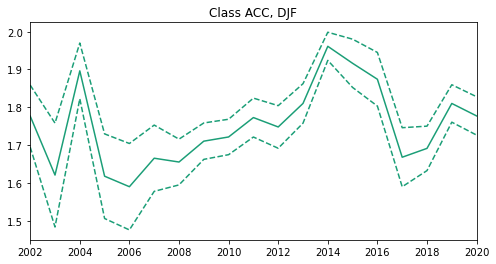

R-squared: 0.568017
slope (95%): 0.022599 +/- 0.010085


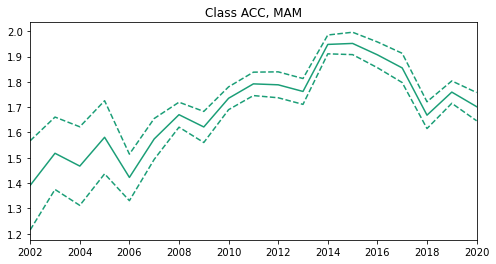

R-squared: 0.556330
slope (95%): 0.019346 +/- 0.008841


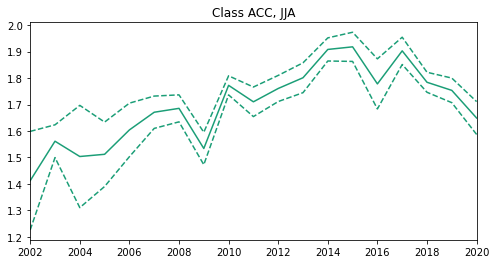

R-squared: 0.428160
slope (95%): 0.013822 +/- 0.008174


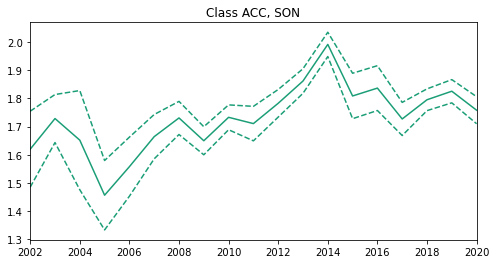

plot_tools:plot_simple_linear_regression: cannot regress empty array


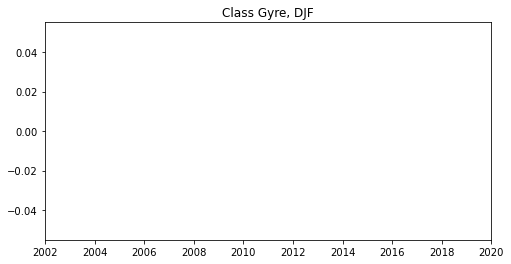

R-squared: 0.218455
slope (95%): -0.027045 +/- 0.649969


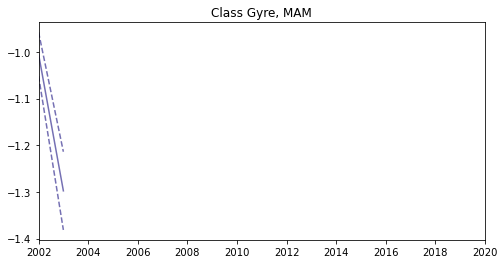

R-squared: 0.771795
slope (95%): 0.036897 +/- 0.254926


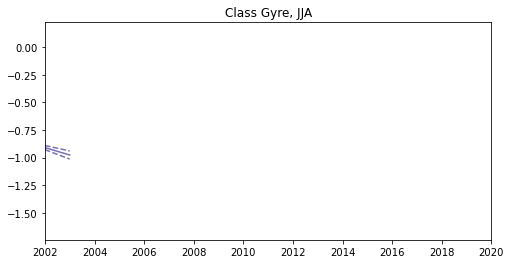

plot_tools:plot_simple_linear_regression: cannot regress empty array


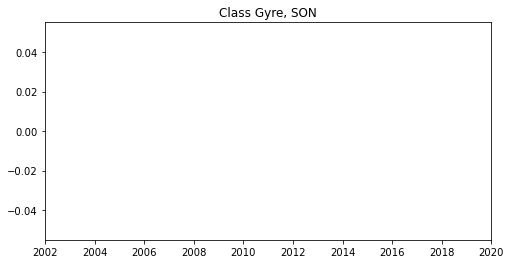

R-squared: 0.271857
slope (95%): 0.028835 +/- 0.024148


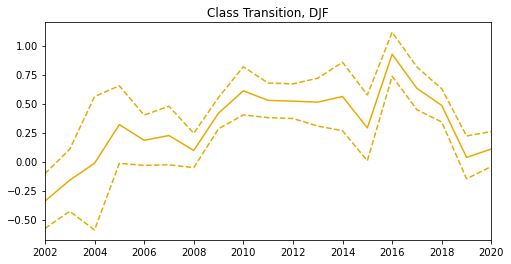

R-squared: 0.366169
slope (95%): 0.040435 +/- 0.027222


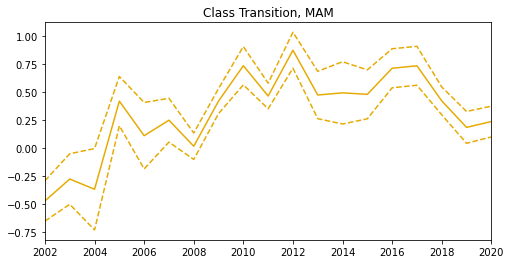

R-squared: 0.462686
slope (95%): 0.049668 +/- 0.037713


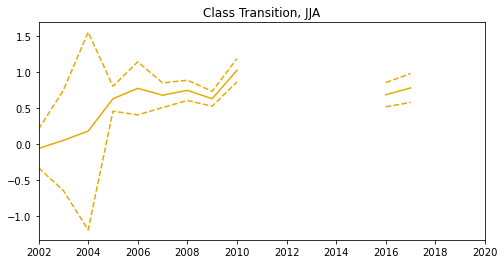

R-squared: 0.036062
slope (95%): -0.010626 +/- 0.036456


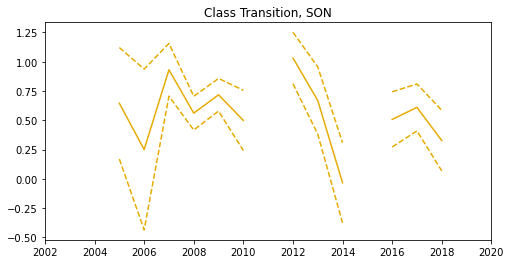

R-squared: 0.183368
slope (95%): -0.011810 +/- 0.015676


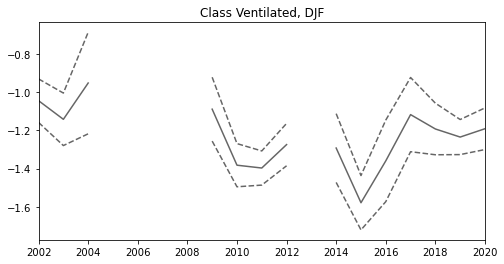

R-squared: 0.047317
slope (95%): -0.006591 +/- 0.016276


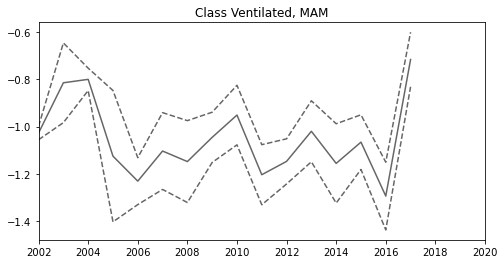

R-squared: 0.712641
slope (95%): -0.056634 +/- 0.041343


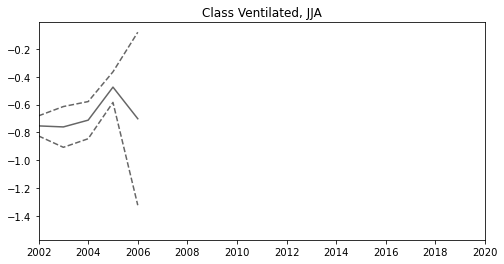

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


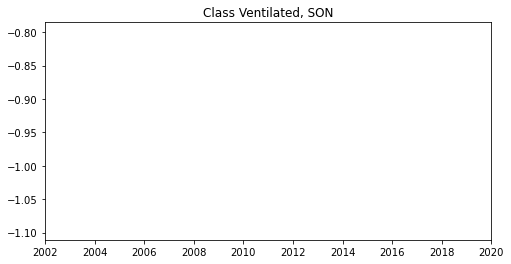

ABSOLUTE SALINITY
analysis.calculate_stats_over_time
R-squared: 0.145029
slope (95%): 0.000671 +/- 0.000834


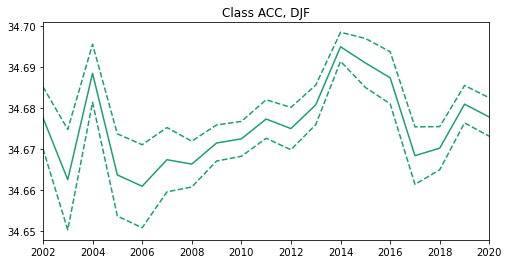

R-squared: 0.568593
slope (95%): 0.002085 +/- 0.000929


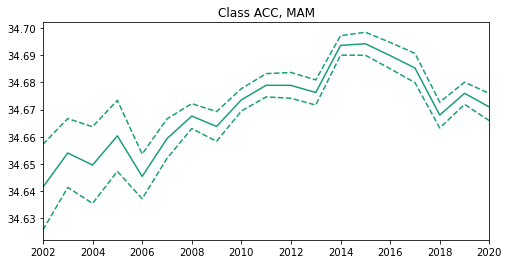

R-squared: 0.562877
slope (95%): 0.001799 +/- 0.000811


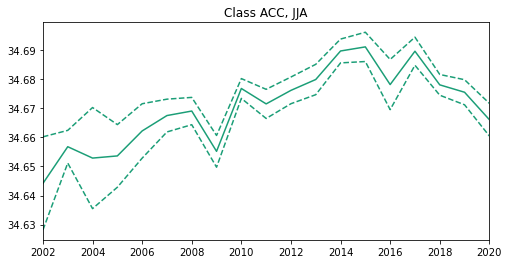

R-squared: 0.435232
slope (95%): 0.001283 +/- 0.000748


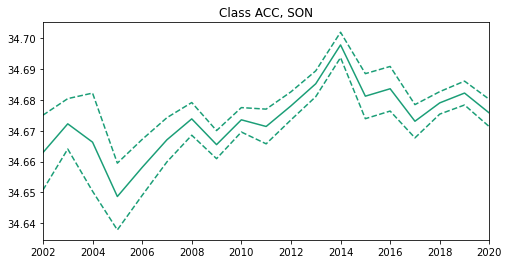

plot_tools:plot_simple_linear_regression: cannot regress empty array


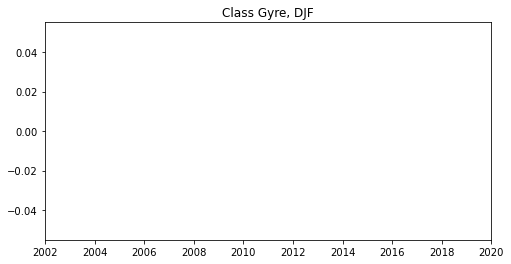

R-squared: 0.209139
slope (95%): -0.001025 +/- 0.025333


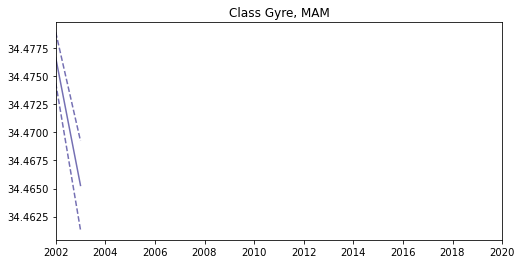

R-squared: 0.959759
slope (95%): 0.004090 +/- 0.010641


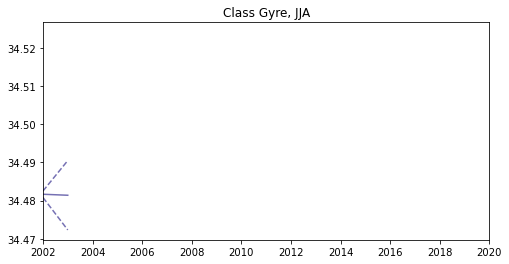

plot_tools:plot_simple_linear_regression: cannot regress empty array


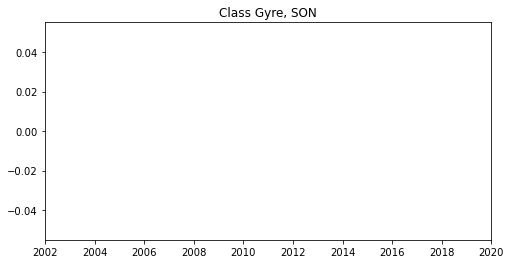

R-squared: 0.271422
slope (95%): 0.002019 +/- 0.001693


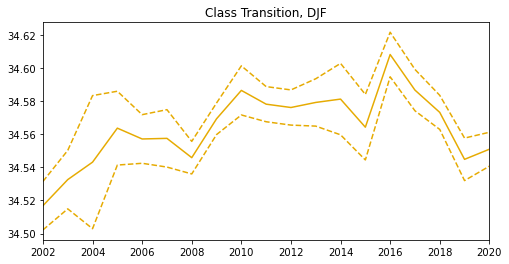

R-squared: 0.389011
slope (95%): 0.002978 +/- 0.001910


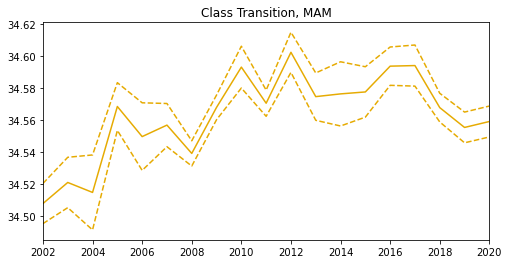

R-squared: 0.514901
slope (95%): 0.003898 +/- 0.002666


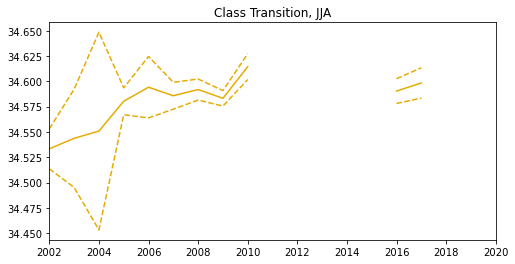

R-squared: 0.020338
slope (95%): -0.000571 +/- 0.002629


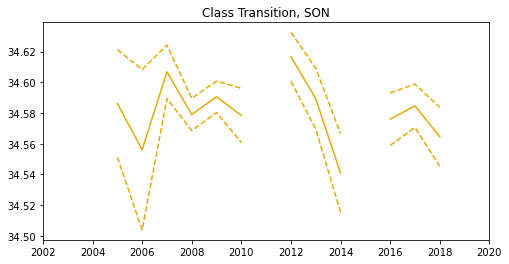

R-squared: 0.168120
slope (95%): -0.000498 +/- 0.000696


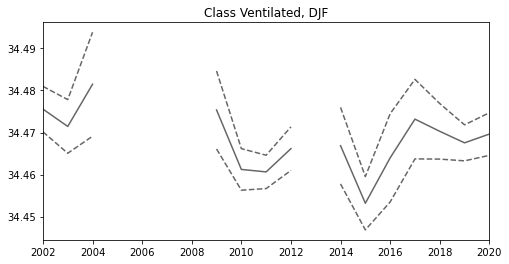

R-squared: 0.037443
slope (95%): -0.000277 +/- 0.000772


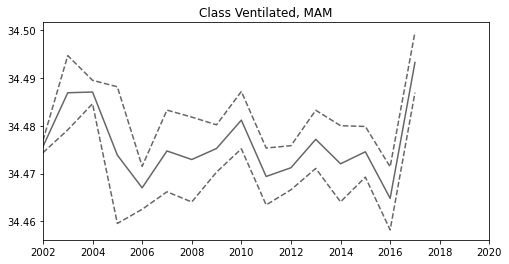

R-squared: 0.637636
slope (95%): -0.002490 +/- 0.002158


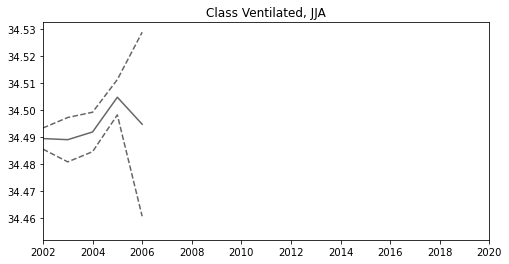

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


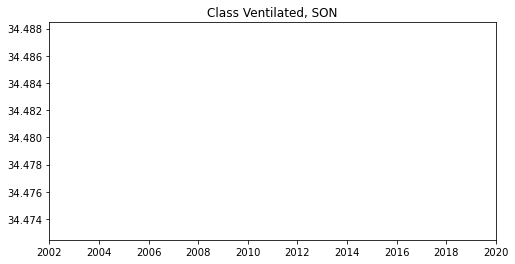

DEPTH OF SURFACE
analysis.calculate_stats_over_time
R-squared: 0.049984
slope (95%): -0.711258 +/- 1.586703


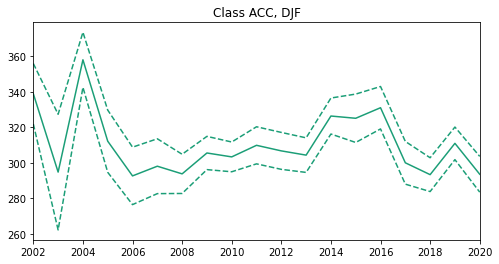

R-squared: 0.067111
slope (95%): 0.864867 +/- 1.650014


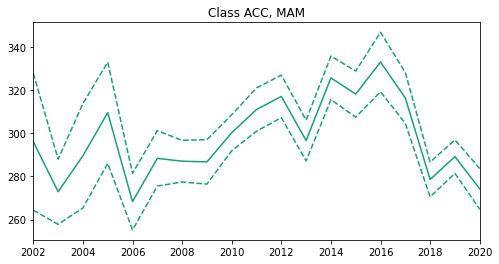

R-squared: 0.056992
slope (95%): 0.547051 +/- 1.138669


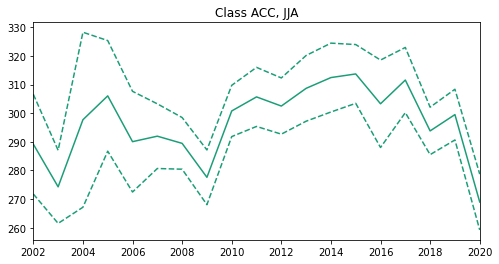

R-squared: 0.024478
slope (95%): 0.398001 +/- 1.285695


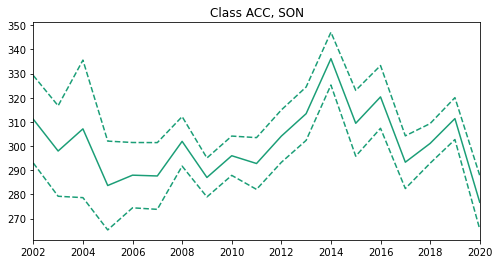

plot_tools:plot_simple_linear_regression: cannot regress empty array


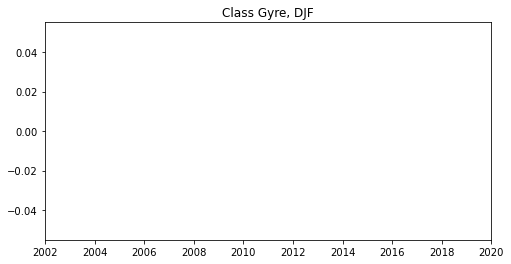

R-squared: 0.820337
slope (95%): -7.559733 +/- 44.952656


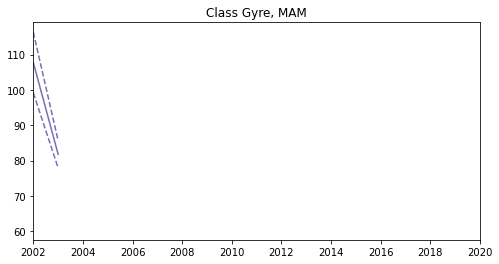

R-squared: 0.320576
slope (95%): -3.087375 +/- 57.109778


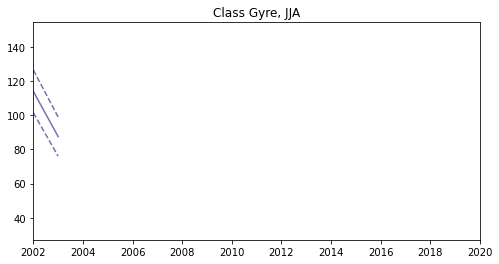

plot_tools:plot_simple_linear_regression: cannot regress empty array


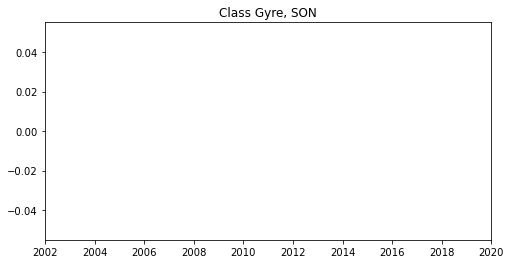

R-squared: 0.012516
slope (95%): 0.295364 +/- 1.342493


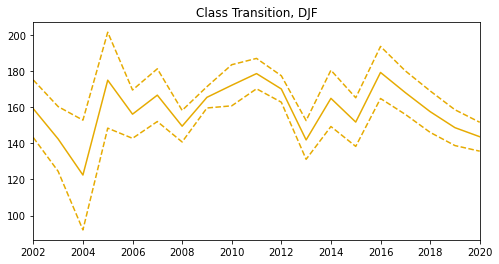

R-squared: 0.012649
slope (95%): 0.377819 +/- 1.708083


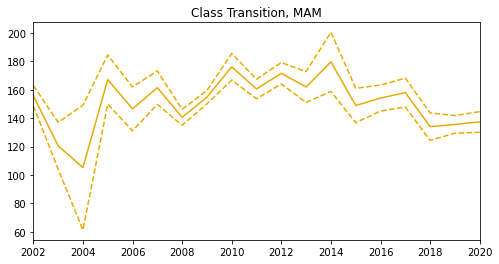

R-squared: 0.009921
slope (95%): 0.247897 +/- 1.744944


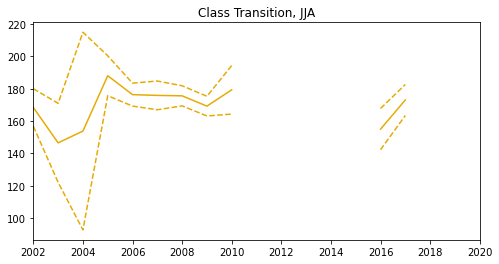

R-squared: 0.364747
slope (95%): -2.146553 +/- 1.879921


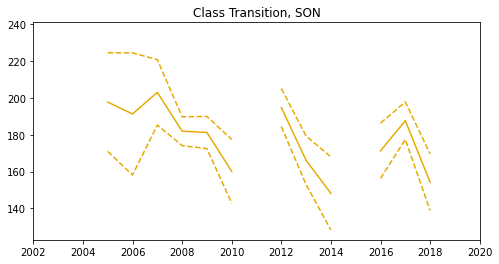

R-squared: 0.117245
slope (95%): -0.654410 +/- 1.129414


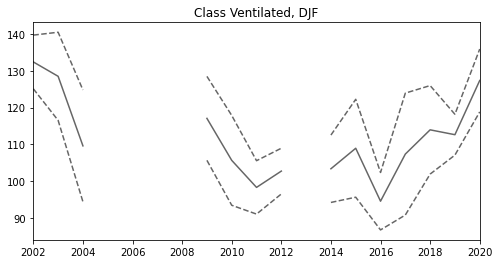

R-squared: 0.049325
slope (95%): -0.674074 +/- 1.628620


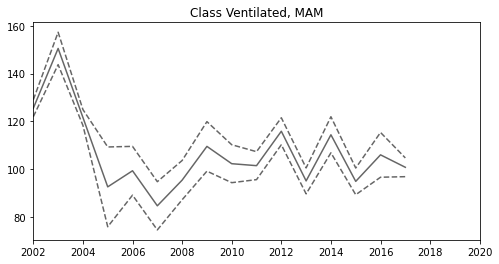

R-squared: 0.395741
slope (95%): 1.937621 +/- 2.752461


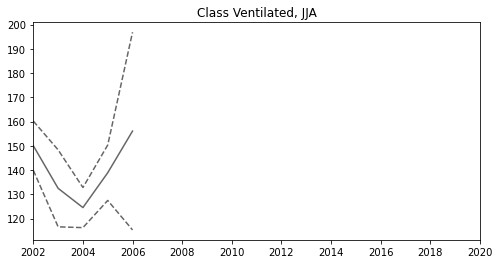

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


R-squared: 0.000000
slope (95%): nan +/- nan


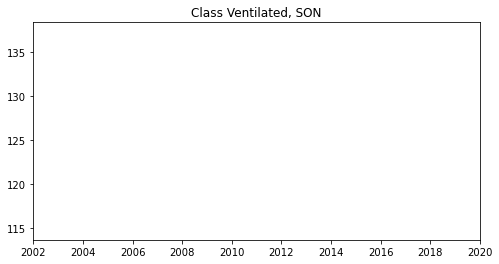

In [25]:
print("CONSERVATIVE TEMPERATURE")
ct276_mean, ct276_std, ct276_N, years = at.calculate_stats_over_time(dfp, varName='ct_on_sig0', sig0index=2)
pt.plot_stats_from_analysis(ploc, dfp, ct276_mean, ct276_std, ct276_N, years, colormap, n_components_selected, \
                            varName='ct276', xlim=[2002, 2020])

print("ABSOLUTE SALINITY")
sa276_mean, sa276_std, sa276_N, years = at.calculate_stats_over_time(dfp, varName='sa_on_sig0', sig0index=2)
pt.plot_stats_from_analysis(ploc, dfp, sa276_mean, sa276_std, sa276_N, years, colormap, n_components_selected, \
                            varName='sa276', xlim=[2002, 2020])

print("DEPTH OF SURFACE")
z276_mean, z276_std, z276_N, years = at.calculate_stats_over_time(dfp, varName='z_on_sig0', sig0index=2)
pt.plot_stats_from_analysis(ploc, dfp, z276_mean, z276_std, z276_N, years, colormap, n_components_selected, \
                            varName='z276', xlim=[2002, 2020])

### CT, SA, and depth of sig0=27.8 surface 

CONSERVATIVE TEMPERATURE
analysis.calculate_stats_over_time
plot_tools:plot_simple_linear_regression: cannot regress empty array


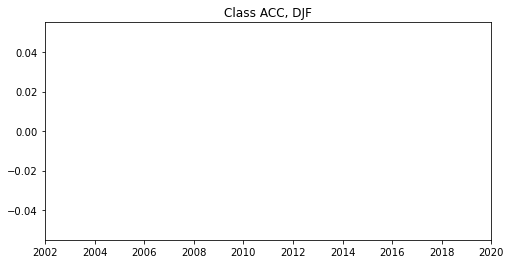

plot_tools:plot_simple_linear_regression: cannot regress empty array


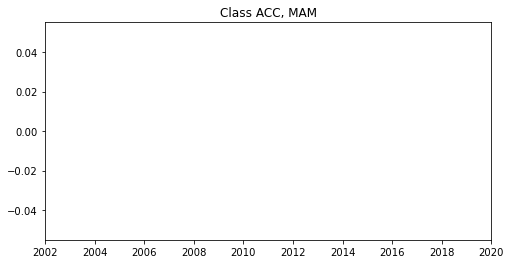

plot_tools:plot_simple_linear_regression: cannot regress empty array


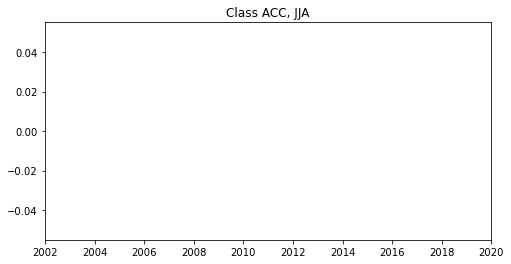

plot_tools:plot_simple_linear_regression: cannot regress empty array


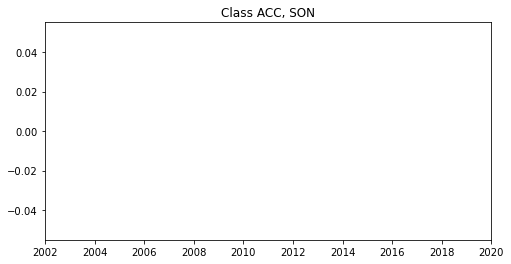

R-squared: 0.018672
slope (95%): 0.008455 +/- 0.031367


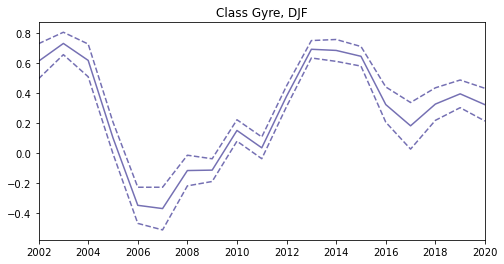

R-squared: 0.041497
slope (95%): 0.011359 +/- 0.027935


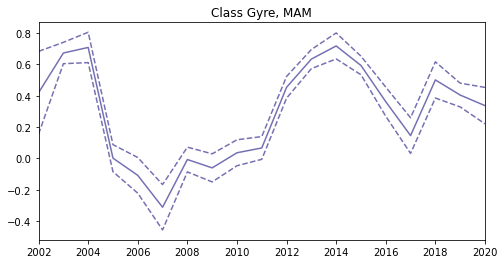

R-squared: 0.034498
slope (95%): 0.011499 +/- 0.031127


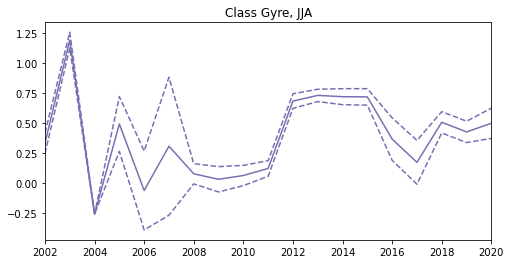

R-squared: 0.040148
slope (95%): 0.020262 +/- 0.052507


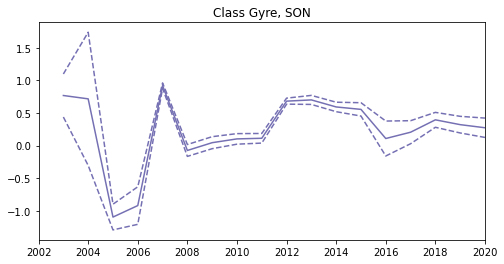

plot_tools:plot_simple_linear_regression: cannot regress empty array


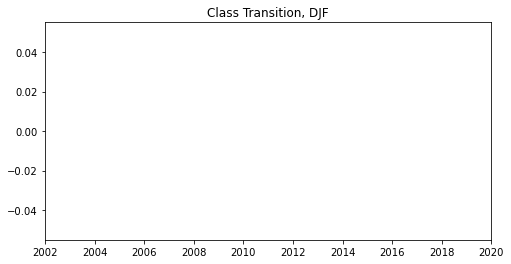

R-squared: 1.000000
slope (95%): 0.048195 +/- nan


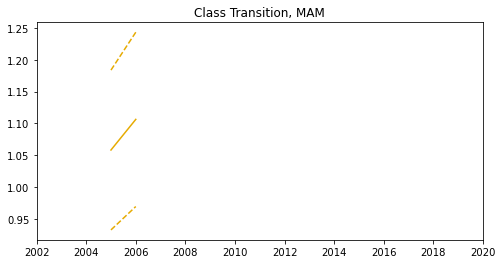

R-squared: 0.145242
slope (95%): 0.005049 +/- 0.037267


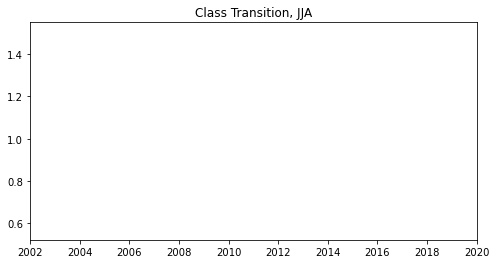

R-squared: 1.000000
slope (95%): -0.009435 +/- nan


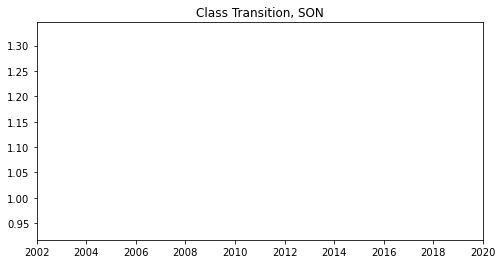

R-squared: 0.111790
slope (95%): 0.011463 +/- 0.016534


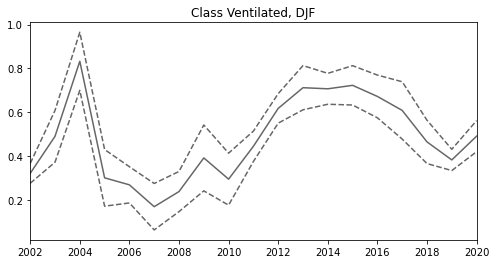

R-squared: 0.000168
slope (95%): 0.000356 +/- 0.014539


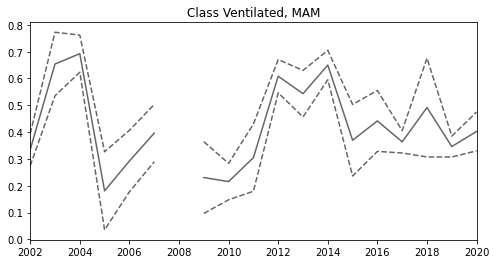

R-squared: 0.024445
slope (95%): 0.005083 +/- 0.019241


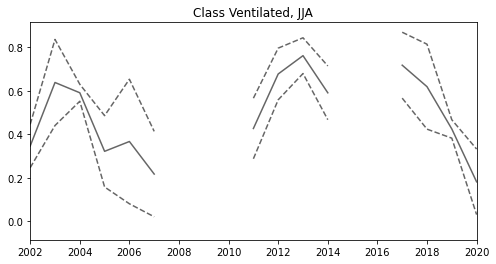

R-squared: 0.007303
slope (95%): 0.003890 +/- 0.031960


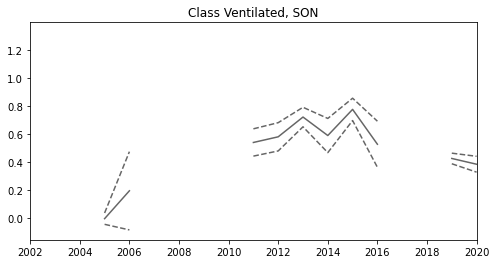

ABSOLUTE SALINITY
analysis.calculate_stats_over_time
plot_tools:plot_simple_linear_regression: cannot regress empty array


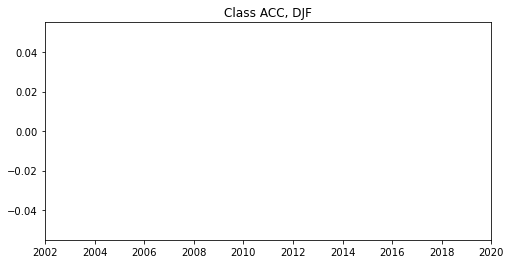

plot_tools:plot_simple_linear_regression: cannot regress empty array


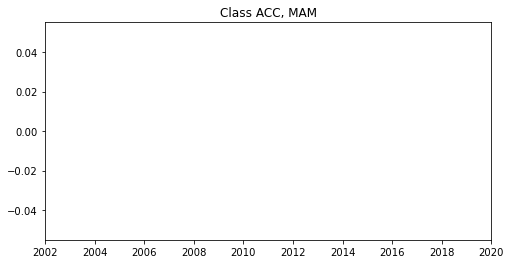

plot_tools:plot_simple_linear_regression: cannot regress empty array


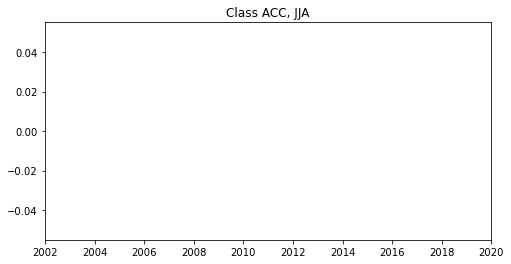

plot_tools:plot_simple_linear_regression: cannot regress empty array


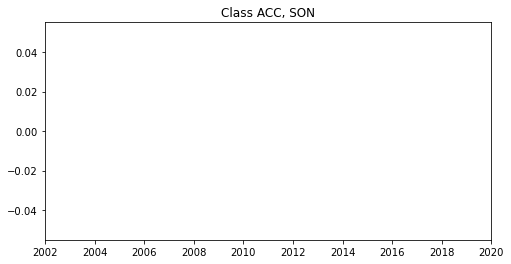

R-squared: 0.016396
slope (95%): 0.000530 +/- 0.002100


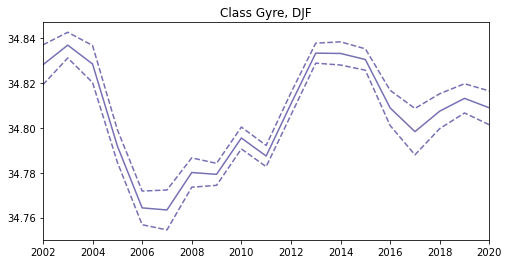

R-squared: 0.042206
slope (95%): 0.000771 +/- 0.001880


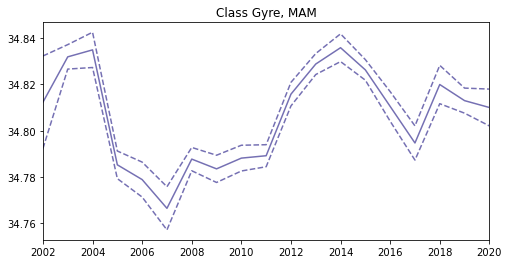

R-squared: 0.033931
slope (95%): 0.000812 +/- 0.002217


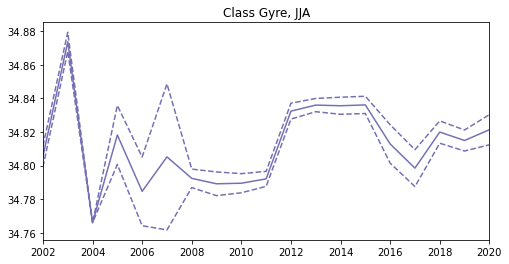

R-squared: 0.031683
slope (95%): 0.001147 +/- 0.003359


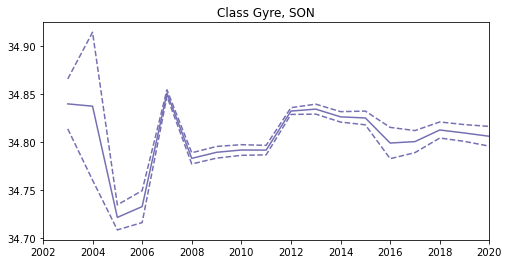

plot_tools:plot_simple_linear_regression: cannot regress empty array


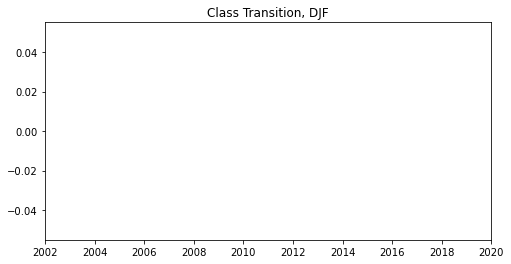

R-squared: 1.000000
slope (95%): 0.004097 +/- nan


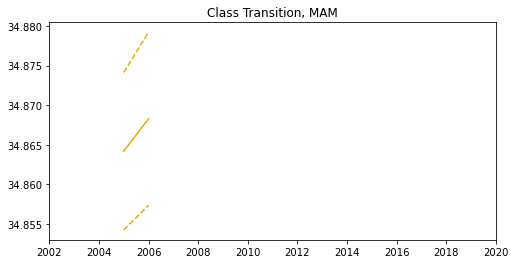

R-squared: 0.153452
slope (95%): 0.000444 +/- 0.003175


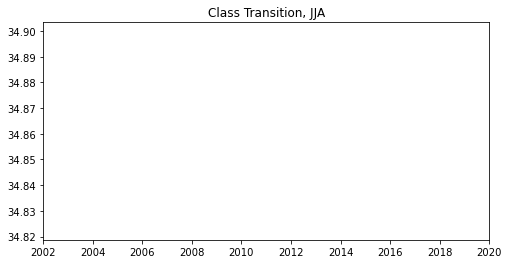

R-squared: 1.000000
slope (95%): -0.000791 +/- nan


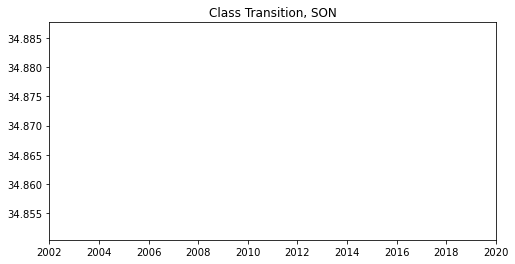

R-squared: 0.106820
slope (95%): 0.000826 +/- 0.001223


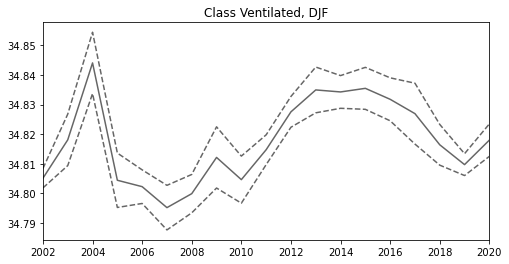

R-squared: 0.000224
slope (95%): 0.000030 +/- 0.001058


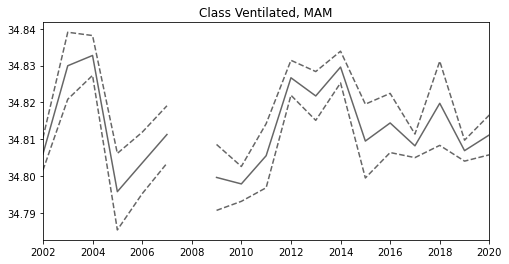

R-squared: 0.030964
slope (95%): 0.000419 +/- 0.001403


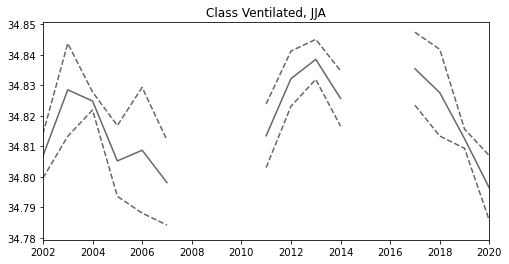

R-squared: 0.001745
slope (95%): 0.000141 +/- 0.002372


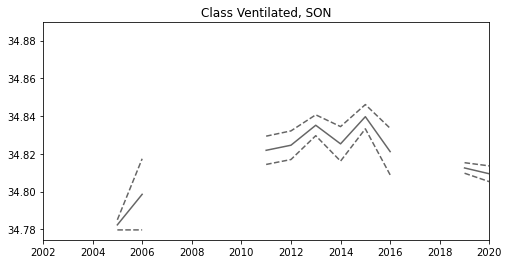

DEPTH OF SURFACE
analysis.calculate_stats_over_time
plot_tools:plot_simple_linear_regression: cannot regress empty array


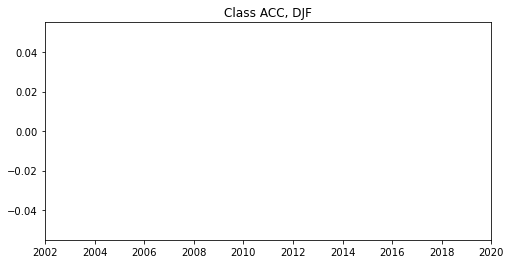

plot_tools:plot_simple_linear_regression: cannot regress empty array


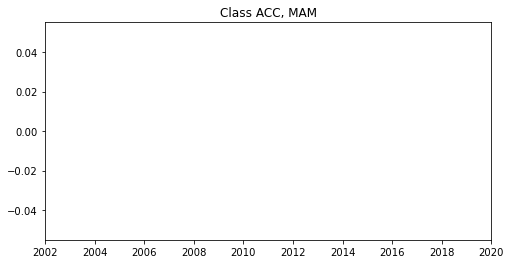

plot_tools:plot_simple_linear_regression: cannot regress empty array


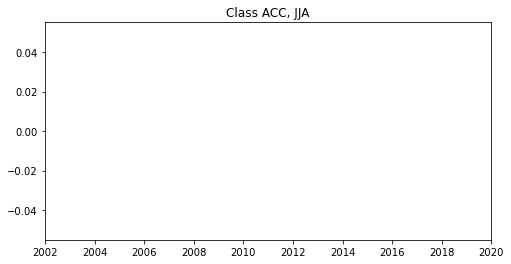

plot_tools:plot_simple_linear_regression: cannot regress empty array


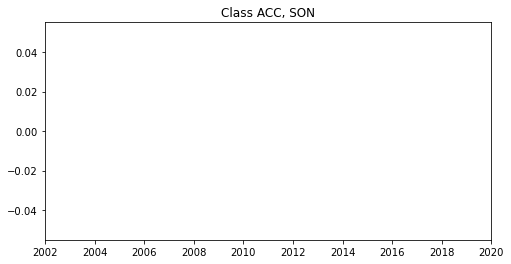

R-squared: 0.032915
slope (95%): -0.516032 +/- 1.431302


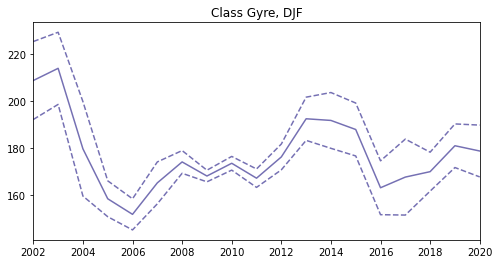

R-squared: 0.027331
slope (95%): -0.468234 +/- 1.429335


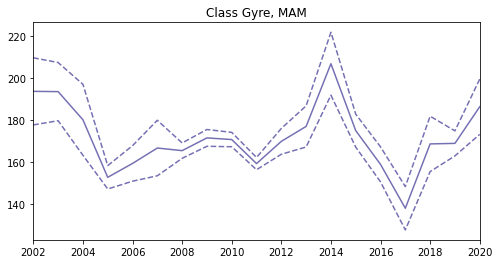

R-squared: 0.002628
slope (95%): -0.279711 +/- 2.788507


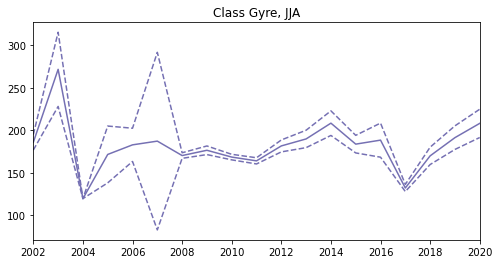

R-squared: 0.016098
slope (95%): 0.881017 +/- 3.650340


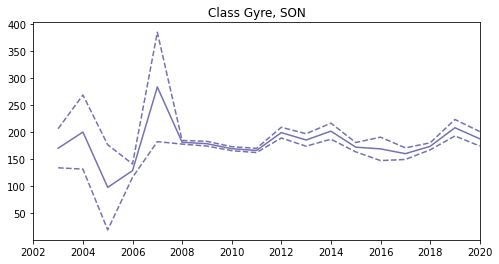

plot_tools:plot_simple_linear_regression: cannot regress empty array


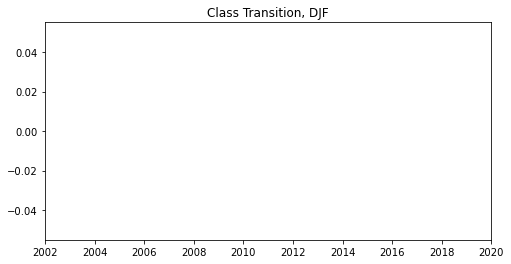

R-squared: 1.000000
slope (95%): -74.579044 +/- nan


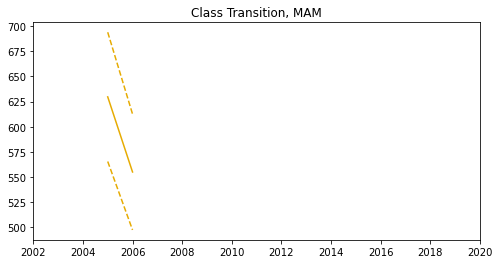

R-squared: 0.167828
slope (95%): -2.407314 +/- 16.309052


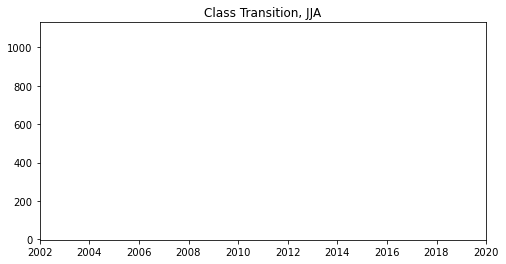

R-squared: 1.000000
slope (95%): -35.653324 +/- nan


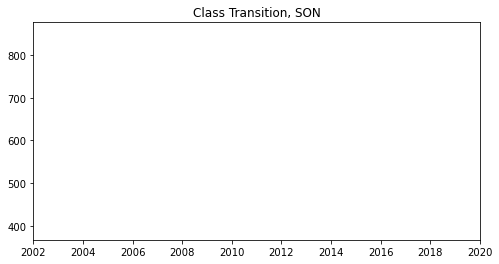

R-squared: 0.169379
slope (95%): 4.660804 +/- 5.281442


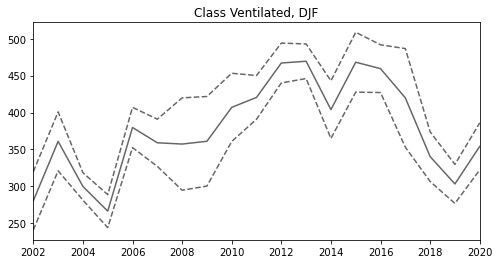

R-squared: 0.132099
slope (95%): 4.054039 +/- 5.507190


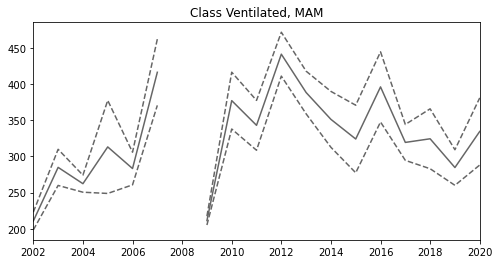

R-squared: 0.464598
slope (95%): 9.684445 +/- 6.229201


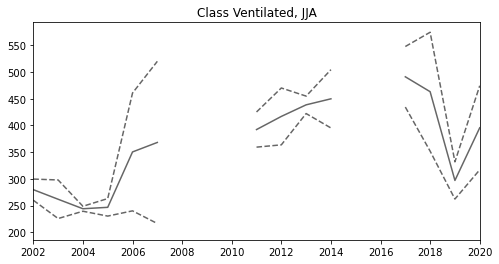

R-squared: 0.030403
slope (95%): -2.516850 +/- 10.014644


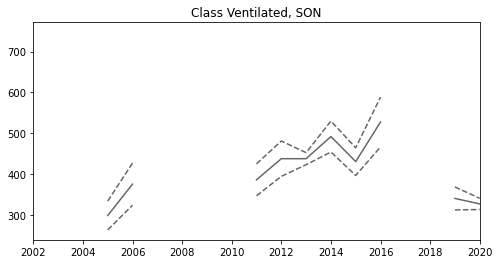

In [26]:
print("CONSERVATIVE TEMPERATURE")
ct278_mean, ct278_std, ct278_N, years = at.calculate_stats_over_time(dfp, varName='ct_on_sig0', sig0index=4)
pt.plot_stats_from_analysis(ploc, dfp, ct278_mean, ct278_std, ct278_N, years, colormap, n_components_selected, \
                            varName='ct278', xlim=[2002, 2020])

print("ABSOLUTE SALINITY")
sa278_mean, sa278_std, sa278_N, years = at.calculate_stats_over_time(dfp, varName='sa_on_sig0', sig0index=4)
pt.plot_stats_from_analysis(ploc, dfp, sa278_mean, sa278_std, sa278_N, years, colormap, n_components_selected, \
                            varName='sa278', xlim=[2002, 2020])

print("DEPTH OF SURFACE")
z278_mean, z278_std, z278_N, years = at.calculate_stats_over_time(dfp, varName='z_on_sig0', sig0index=4)
pt.plot_stats_from_analysis(ploc, dfp, z278_mean, z278_std, z278_N, years, colormap, n_components_selected, \
                            varName='z278', xlim=[2002, 2020])